# Ligand-Based Virtual Screening and Machine Learning Framework for ABL1 Inhibitor Discovery  
### Independent Computational Chemistry Project (2024)

This notebook documents an independently designed and implemented ligand-based screening workflow developed in 2024.

The overall structure of the screening pipeline was conceptually informed by publicly available cheminformatics materials from the Volkamer Lab (Freie Universität Berlin).  

All implementation, dataset curation, model training, and analysis presented here were carried out independently.



This notebook implements a ligand-based computational pipeline for identifying potential ABL1 inhibitors using cheminformatics filtering, similarity screening, clustering, scaffold analysis, and supervised learning.

Reference ligand: Dasatinib.
Data source: ChEMBL bioactivity dataset.


## **COMPOUND DATA ACQUISITION FROM ChEMBL**
**Extract data from ChEMBL (compound, activity data) pairs for a target of interest**

In [ ]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory
import numpy as numpy
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
import csv
import os
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.Chem import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFingerprintGenerator
from scipy.stats import linregress
from rdkit.ML.Cluster import Butina
import random as random
import time

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [3]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [4]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

For the example of Tyrosine Kinase Inhibitors (TKIs) like Imatinib, Dasatinib, and Nilotinib, which target the BCR-ABL kinase, we want to obtain the UniProt ID of the ABL1 kinase. ABL1 is the part of the BCR-ABL fusion protein that possesses the tyrosine kinase activity and is targeted by these drugs in the treatment of chronic myeloid leukemia (CML) and other cancers.

https://www.cancer.org/cancer/types/thyroid-cancer/treating/targeted-therapy.html


## 1. Data Curation and Activity Normalization

The dataset contains experimentally reported IC50 values for ABL1 inhibitors.

IC50 values (nM) are converted to pIC50 to stabilize scale and improve interpretability.


In [5]:
uniprot_id = "P00519" # uniprot id of ABL1_HUMAN


In [ ]:
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
"""
It's specifying that only the "target_chembl_id," "organism," "pref_name" (preferred name), 
and "target_type" fields should be included in the results.
"""
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [ ]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Tyrosine-protein kinase ABL,CHEMBL1862,SINGLE PROTEIN
1,Homo sapiens,Tyrosine-protein kinase ABL,CHEMBL1862,SINGLE PROTEIN
2,Homo sapiens,Bcr/Abl fusion protein,CHEMBL2096618,CHIMERIC PROTEIN
3,Homo sapiens,Tyrosine-protein kinase ABL,CHEMBL2111414,PROTEIN FAMILY
4,Homo sapiens,Ras and Rab interactor 1/Tyrosine-protein kina...,CHEMBL3885630,PROTEIN-PROTEIN INTERACTION
5,Homo sapiens,Transcription factor ETV6/Tyrosine-protein kin...,CHEMBL3885645,CHIMERIC PROTEIN
6,Homo sapiens,Baculoviral IAP repeat-containing protein 2/BC...,CHEMBL4296119,PROTEIN-PROTEIN INTERACTION
7,Homo sapiens,E3 ubiquitin-protein ligase XIAP/BCR/ABL,CHEMBL4296120,PROTEIN-PROTEIN INTERACTION
8,Homo sapiens,Cereblon/BCR/ABL,CHEMBL4296137,PROTEIN-PROTEIN INTERACTION
9,Homo sapiens,VHL/ABL1,CHEMBL4523725,PROTEIN-PROTEIN INTERACTION


From the entries that are given in output above, we are interested in entry 0 or 1

In [8]:
target = targets.loc[0]
target

organism                           Homo sapiens
pref_name           Tyrosine-protein kinase ABL
target_chembl_id                     CHEMBL1862
target_type                      SINGLE PROTEIN
Name: 0, dtype: object

**We selected ChEMBL id CHEMBL2041. We wil now save it in the variable chembl_id.**

In [9]:
chembl_id = targets["target_chembl_id"].iloc[0]
print(f"The target ChEMBL ID is {chembl_id}")

The target ChEMBL ID is CHEMBL1862


In [10]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 2307, <class 'chembl_webresource_client.query_set.QuerySet'>


In [11]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 146141,
 'assay_chembl_id': 'CHEMBL806527',
 'assay_description': 'Radioligand displacement assay for the binding of [125I]Glu-Pro-Gln-pTyr-Glu-Glu-Ile-Pro-Ile-Tyr-Leu to ABL SH2 domain',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL13462',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '4000.0',
 'target_chembl_id': 'CHEMBL1862',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '4.0'}

**To Download bioactivity data from ChEMBL in the form of pandas dataframe.**

In [12]:
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (2307, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,146141,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL13462,=,nM,4000.0,CHEMBL1862,Homo sapiens,IC50,uM,4.0
1,146143,CHEMBL762575,Inhibition of [35S]-labeled SH2-GST Abl bindin...,B,CHEMBL13462,=,nM,16000.0,CHEMBL1862,Homo sapiens,IC50,uM,16.0
2,148569,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL414123,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50,uM,15.0
3,148571,CHEMBL762575,Inhibition of [35S]-labeled SH2-GST Abl bindin...,B,CHEMBL414123,=,nM,2900.0,CHEMBL1862,Homo sapiens,IC50,uM,2.9
4,152122,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL413629,=,nM,1800.0,CHEMBL1862,Homo sapiens,IC50,uM,1.8


In [13]:
bioactivities_df["units"].unique()

array(['uM', 'nM', 'M', 'microM', "10'-6M", "10'-8M", "10'-7M", '10^-8M'],
      dtype=object)

In [14]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,146141,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL13462,=,nM,4000.0,CHEMBL1862,Homo sapiens,IC50
1,146143,CHEMBL762575,Inhibition of [35S]-labeled SH2-GST Abl bindin...,B,CHEMBL13462,=,nM,16000.0,CHEMBL1862,Homo sapiens,IC50
2,148569,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL414123,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50
3,148571,CHEMBL762575,Inhibition of [35S]-labeled SH2-GST Abl bindin...,B,CHEMBL414123,=,nM,2900.0,CHEMBL1862,Homo sapiens,IC50
4,152122,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL413629,=,nM,1800.0,CHEMBL1862,Homo sapiens,IC50


**Preprocess and filter bioactivity data**

**1. Convert standard_value’s datatype from object to float**

**2. Delete entries with missing values**

**3. Keep only entries with standard_unit == nM**

**4. Delete duplicate molecules**

**5. Reset DataFrame index**

**6. Rename columns**

**1. Convert datatype of “standard_value” from “object” to “float”**

In [15]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [16]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

**2. Delete entries with missing values**

In [17]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (2307, 11)


**3. Keep only entries with “standard_unit == nM”**

In [18]:
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM']
Number of non-nM entries:    0


In [19]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [20]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (2307, 11)


**4. Delete duplicate molecules**


In [21]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")
# Here, we only keep the first one in case there is a duplicate.

DataFrame shape: (1476, 11)


**5. Reset “DataFrame” index**

In [22]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,146141,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL13462,=,nM,4000.0,CHEMBL1862,Homo sapiens,IC50
1,148569,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL414123,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50
2,152122,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL413629,=,nM,1800.0,CHEMBL1862,Homo sapiens,IC50
3,154553,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL301845,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50
4,159483,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL58478,=,nM,1700.0,CHEMBL1862,Homo sapiens,IC50


**6. Rename columns**

In [23]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,146141,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL13462,=,nM,4000.0,CHEMBL1862,Homo sapiens,IC50
1,148569,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL414123,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50
2,152122,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL413629,=,nM,1800.0,CHEMBL1862,Homo sapiens,IC50
3,154553,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL301845,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50
4,159483,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL58478,=,nM,1700.0,CHEMBL1862,Homo sapiens,IC50


In [24]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (1476, 11)


In [ ]:
# Fetching compound data from ChEMBL

compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [ ]:
# Downloading compound data from ChEMBL
compounds = list(tqdm(compounds_provider))

compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

  0%|          | 0/1476 [00:00<?, ?it/s]

DataFrame shape: (1476, 2)


In [ ]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL44,{'canonical_smiles': 'O=c1c(-c2ccc(O)cc2)coc2c...
1,CHEMBL9514,{'canonical_smiles': 'COC(=O)Nc1nc2cc(C(=O)c3c...
2,CHEMBL13462,{'canonical_smiles': 'CC(=O)N[C@@H](Cc1ccc(OP(...
3,CHEMBL276711,{'canonical_smiles': 'Cc1cc(C)c(/C=C2\C(=O)Nc3...
4,CHEMBL535,{'canonical_smiles': 'CCN(CC)CCNC(=O)c1c(C)[nH...


**Remove entries with missing molecule structure entry**

In [28]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (1474, 2)



**Delete duplicate molecules**

In [29]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (1474, 2)


**Get molecules with canonical SMILES**

In [30]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [31]:
compounds_df["smiles"] = compounds_df["molecule_structures"].apply(lambda x: x.get("canonical_smiles") if isinstance(x, dict) else None)
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")


DataFrame shape: (1474, 2)


In [ ]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (1474, 2)


In [33]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 1476


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [34]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 1474


Index(['molecule_chembl_id', 'smiles'], dtype='object')

**To merge both datasets bioactivities_df and compounds_df**

In [ ]:
# Check if 'molecule_structures' column exists before dropping
if 'molecule_structures' in compounds_df.columns:
    compounds_df.drop("molecule_structures", axis=1, inplace=True)

# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
    how="inner",  # Specify the type of merge if needed (default is 'inner')
)

print(f"Dataset with {output_df.shape[0]} entries.")



Dataset with 1474 entries.


In [36]:
output_df.dtypes

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [37]:
output_df.head(10) # Show first 10 entries

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL13462,4000.0,nM,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
1,CHEMBL414123,15000.0,nM,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...
2,CHEMBL413629,1800.0,nM,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...
3,CHEMBL301845,15000.0,nM,CC[C@H](NC(=O)[C@H](Cc1ccc(OP(=O)(O)O)cc1)NC(C...
4,CHEMBL58478,1700.0,nM,CC(=O)N[C@@H](Cc1ccc(C(F)(F)P(=O)(O)O)cc1)C(=O...
5,CHEMBL298813,1600.0,nM,CC[C@H](NC(=O)[C@H](Cc1ccc(C(F)(F)P(=O)(O)O)cc...
6,CHEMBL293803,4900.0,nM,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
7,CHEMBL294692,1200.0,nM,CC(=O)N[C@@H](Cc1ccc(C(F)(F)P(=O)(O)O)cc1)C(=O...
8,CHEMBL294420,1200.0,nM,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...
9,CHEMBL299477,7900.0,nM,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...


**In this, IC50 values are there. To plot them effectively in one graph, it is required to convert them to the logarithm scale(pIC50)**

In [ ]:
import math

# Define the conversion function
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

# Apply conversion to each row of the compounds DataFrame using a for loop
pIC50_values = []
for index, row in output_df.iterrows():
    pIC50_values.append(convert_ic50_to_pic50(row["IC50"]))

# Add the pIC50 values to the DataFrame
output_df["pIC50"] = pIC50_values

output_df.head(10)


,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL13462,4000.0,nM,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,5.397940
1,CHEMBL414123,15000.0,nM,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...,4.823909
2,CHEMBL413629,1800.0,nM,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...,5.744727
3,CHEMBL301845,15000.0,nM,CC[C@H](NC(=O)[C@H](Cc1ccc(OP(=O)(O)O)cc1)NC(C...,4.823909
4,CHEMBL58478,1700.0,nM,CC(=O)N[C@@H](Cc1ccc(C(F)(F)P(=O)(O)O)cc1)C(=O...,5.769551
5,CHEMBL298813,1600.0,nM,CC[C@H](NC(=O)[C@H](Cc1ccc(C(F)(F)P(=O)(O)O)cc...,5.795880
6,CHEMBL293803,4900.0,nM,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,5.309804
7,CHEMBL294692,1200.0,nM,CC(=O)N[C@@H](Cc1ccc(C(F)(F)P(=O)(O)O)cc1)C(=O...,5.920819
8,CHEMBL294420,1200.0,nM,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,5.920819
9,CHEMBL299477,7900.0,nM,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,5.102373


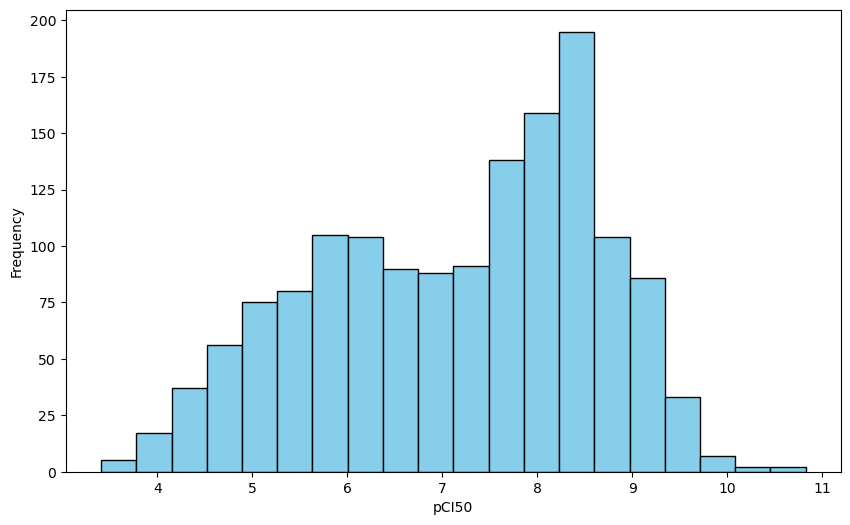

In [39]:
# Plotting histogram for pIC50 values
plt.figure(figsize=(10, 6))
plt.hist(output_df["pIC50"], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('pCI50')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

**5 Molecules with highest pIC50 values. They will be most active.**

In [41]:
output_df.drop("smiles", axis=1).head(5)

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL2347725,0.015,nM,10.823909,<rdkit.Chem.rdchem.Mol object at 0x16583d6c0>
1,CHEMBL2347722,0.021,nM,10.677781,<rdkit.Chem.rdchem.Mol object at 0x16583d7e0>
2,CHEMBL2347723,0.064,nM,10.193820,<rdkit.Chem.rdchem.Mol object at 0x16583d780>
3,CHEMBL2347711,0.064,nM,10.193820,<rdkit.Chem.rdchem.Mol object at 0x16583dc00>
4,CHEMBL2347719,0.110,nM,9.958607,<rdkit.Chem.rdchem.Mol object at 0x16583d900>


In [42]:
# Prepare saving the dataset: Drop the ROMol column
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (1474, 5)


In [43]:
output_df

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL2347725,0.015,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909
1,CHEMBL2347722,0.021,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781
2,CHEMBL2347723,0.064,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820
3,CHEMBL2347711,0.064,nM,CCNC(=O)Nc1nc2ccc(-c3ccccc3OCC)cc2s1,10.193820
4,CHEMBL2347719,0.110,nM,CCNC(=O)Nc1nc2ccc(-c3ccc(N)cc3OC)cc2s1,9.958607
...,...,...,...,...,...
1469,CHEMBL551838,236000.000,nM,Cc1ccc(C(=O)Nc2cc(C(F)(F)F)ccc2F)cc1/C=C/n1cnc...,3.627088
1470,CHEMBL551030,243000.000,nM,Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1/C=C/n1cnc2...,3.614394
1471,CHEMBL559438,267000.000,nM,Cc1ccc(C(=O)Nc2ncc(C(C)(C)C)s2)cc1/C=C/n1cnc2c...,3.573489
1472,CHEMBL3105076,380000.000,nM,Nc1ncnc2[nH]c(C(F)(F)F)nc12,3.420216


**To create a csv file on mac and save the data in that csv file**

In [44]:
import os
import csv
import pandas as pd

current_directory = os.getcwd()
csv_file_name = "RET_compounds.csv"
csv_file_path = os.path.join(current_directory, csv_file_name)

# Check if the file already exists
if not os.path.isfile(csv_file_path):
    # Create a blank CSV file
    with open(csv_file_path, 'w', newline='') as csv_file:
        # Create a CSV writer object
        csv_writer = csv.writer(csv_file)
        
        # You can add headers if needed
        # csv_writer.writerow(['Header1', 'Header2', 'Header3'])
        
        # Assuming output_df is a Pandas DataFrame with data
        output_df.to_csv(csv_file, index=False, header=True)

    print(f"CSV file '{csv_file_name}' created with predefined data in the same folder as the notebook.")
else:
    print(f"File '{csv_file_name}' already exists in the folder.")


File 'RET_compounds.csv' already exists in the folder.


In [45]:
# Specify the path to the CSV file
csv_file_path = os.path.join(current_directory, csv_file_name)

# Specify the column to remove
column_to_remove = 'ROMol'

# Check if the CSV file exists
if os.path.isfile(csv_file_path):
    # Check if the specified column exists in the DataFrame
    if column_to_remove in output_df.columns:
        # Drop the specified column
        output_df = output_df.drop(columns=[column_to_remove])

        # Save the updated DataFrame to the CSV file
        output_df.to_csv(csv_file_path, index=False)

        print(f"Column '{column_to_remove}' removed and DataFrame saved to the CSV file.")
    else:
        print(f"Column '{column_to_remove}' does not exist in the DataFrame.")
else:
    print(f"File '{csv_file_name}' does not exist in the folder. Please create it first.")

Column 'ROMol' does not exist in the DataFrame.


In [46]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL2347725,0.015,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909
1,CHEMBL2347722,0.021,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781
2,CHEMBL2347723,0.064,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820
3,CHEMBL2347711,0.064,nM,CCNC(=O)Nc1nc2ccc(-c3ccccc3OCC)cc2s1,10.193820
4,CHEMBL2347719,0.110,nM,CCNC(=O)Nc1nc2ccc(-c3ccc(N)cc3OC)cc2s1,9.958607


In [47]:
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (1474, 5)


## **Molecular filtering: ADME and lead-likeness criteria**

First, let us work on 4 molecules instead of the entire dataset.

In [48]:
smiles = [
    "CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(C(=O)NC(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N1)C(C(C)CC=CC)O)C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C",
    "CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C",
    "CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=C(C)C=CC2=C(CCCC2(C)C)C)C)C",
    "CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O",
]
names = ["cyclosporine", "clozapine", "beta-carotene", "cannabidiol"]

,name,smiles,ROMol
0,cyclosporine,CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...,
1,clozapine,CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C,
2,beta-carotene,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=...,
3,cannabidiol,CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O,

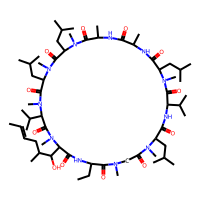
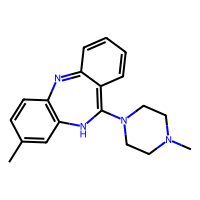
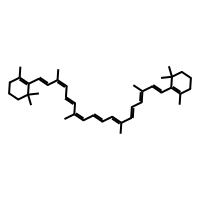
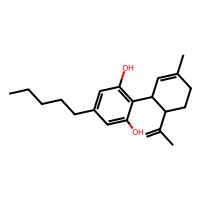

In [49]:
molecules = pd.DataFrame({"name": names, "smiles": smiles})
PandasTools.AddMoleculeColumnToFrame(molecules, "smiles")
molecules

,name,smiles,ROMol,molecular_weight,n_hba,n_hbd,logp,color
0,cyclosporine,CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...,,1201.841368,12,5,3.26900,red
1,clozapine,CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C,,306.184447,4,1,1.68492,green
2,beta-carotene,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=...,,536.438202,0,0,12.60580,blue
3,cannabidiol,CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O,,314.224580,2,2,5.84650,cyan

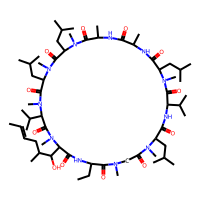
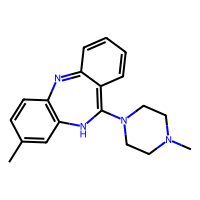
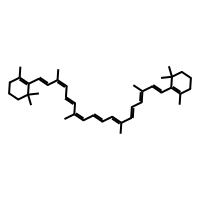
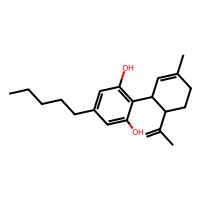

In [50]:
molecules["molecular_weight"] = molecules["ROMol"].apply(Descriptors.ExactMolWt)
molecules["n_hba"] = molecules["ROMol"].apply(Descriptors.NumHAcceptors)
molecules["n_hbd"] = molecules["ROMol"].apply(Descriptors.NumHDonors)
molecules["logp"] = molecules["ROMol"].apply(Descriptors.MolLogP)
# Colors are used for plotting the molecules later
molecules["color"] = ["red", "green", "blue", "cyan"]
molecules

In [51]:
ro5_properties = {
    "molecular_weight": (500, "molecular weight (Da)"),
    "n_hba": (10, "# HBA"),
    "n_hbd": (5, "# HBD"),
    "logp": (5, "logP"),
}

In [52]:
"""
# Start 1x4 plot frame
fig, axes = plt.subplots(figsize=(10, 2.5), nrows=1, ncols=4)
x = numpy.arange(1, len(molecules) + 1)
colors = ["red", "green", "blue", "cyan"]

# Create subplots
for index, (key, (threshold, title)) in enumerate(ro5_properties.items()):
    axes[index].bar([1, 2, 3, 4], molecules[key][:4], color=colors)
    axes[index].axhline(y=threshold, color="black", linestyle="dashed")
    axes[index].set_title(title)
    axes[index].set_xticks([])

# Add legend
legend_elements = [
    mpatches.Patch(color=row["color"], label=row["name"]) for index, row in molecules.iterrows()
]
legend_elements.append(Line2D([0], [0], color="black", ls="dashed", label="Threshold"))
fig.legend(handles=legend_elements, bbox_to_anchor=(1.2, 0.8))

# Fit subplots and legend into figure
plt.tight_layout()
plt.show()
"""


'\n# Start 1x4 plot frame\nfig, axes = plt.subplots(figsize=(10, 2.5), nrows=1, ncols=4)\nx = numpy.arange(1, len(molecules) + 1)\ncolors = ["red", "green", "blue", "cyan"]\n\n# Create subplots\nfor index, (key, (threshold, title)) in enumerate(ro5_properties.items()):\n    axes[index].bar([1, 2, 3, 4], molecules[key][:4], color=colors)\n    axes[index].axhline(y=threshold, color="black", linestyle="dashed")\n    axes[index].set_title(title)\n    axes[index].set_xticks([])\n\n# Add legend\nlegend_elements = [\n    mpatches.Patch(color=row["color"], label=row["name"]) for index, row in molecules.iterrows()\n]\nlegend_elements.append(Line2D([0], [0], color="black", ls="dashed", label="Threshold"))\nfig.legend(handles=legend_elements, bbox_to_anchor=(1.2, 0.8))\n\n# Fit subplots and legend into figure\nplt.tight_layout()\nplt.show()\n'

## 2. Physicochemical Filtering (Lipinski Rule of 5)

Compounds are filtered using standard drug-likeness criteria to remove obvious outliers prior to similarity screening.


In [53]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    """
    n_hba (Number of Hydrogen Bond Acceptors): This descriptor counts the number of atoms in a molecule 
    capable of accepting hydrogen bonds. Hydrogen bond acceptors are typically atoms with lone pairs of electrons, 
    such as oxygen or nitrogen atoms. In biological and chemical contexts, hydrogen bond acceptors play a crucial role 
    in interactions between molecules.
    """
    n_hba = Descriptors.NumHAcceptors(molecule)
    """
    n_hbd (Number of Hydrogen Bond Donors): This descriptor counts the number of atoms in a molecule that can donate 
    hydrogen bonds. Hydrogen bond donors are typically atoms with hydrogen atoms covalently bonded to more electronegative 
    atoms like oxygen or nitrogen. These hydrogen atoms can form hydrogen bonds with other electronegative atoms.
    """
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )

In [54]:
for name, smiles in zip(molecules["name"], molecules["smiles"]):
    print(f"Ro5 fulfilled for {name}: {calculate_ro5_properties(smiles)['ro5_fulfilled']}")

Ro5 fulfilled for cyclosporine: False
Ro5 fulfilled for clozapine: True
Ro5 fulfilled for beta-carotene: False
Ro5 fulfilled for cannabidiol: True


**As per the Rule of Five (Ro5), cyclosporin and betacarotene are predicted to exhibit low bioavailability. Nevertheless, given their status as approved drugs, they serve as notable instances illustrating that the Ro5 can function as a warning but may not be exclusively relied upon as a strict filter.**

**To apply Ro5 to the RET dataset**

In [55]:
molecules = pd.read_csv('RET_compounds.csv')
print(molecules.shape)
molecules.head()

(1474, 5)


,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL2347725,0.015,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909
1,CHEMBL2347722,0.021,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781
2,CHEMBL2347723,0.064,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820
3,CHEMBL2347711,0.064,nM,CCNC(=O)Nc1nc2ccc(-c3ccccc3OCC)cc2s1,10.193820
4,CHEMBL2347719,0.110,nM,CCNC(=O)Nc1nc2ccc(-c3ccc(N)cc3OC)cc2s1,9.958607


In [56]:
ro5_properties = molecules["smiles"].apply(calculate_ro5_properties)
ro5_properties.head()

,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,425.188546,6,2,3.3408,True
1,412.156912,6,2,3.4256,True
2,343.099062,5,3,3.0857,True
3,341.119798,4,2,4.5034,True
4,342.115047,5,3,3.6955,True


In [57]:
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL2347725,0.015,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909,425.188546,6,2,3.3408,True
1,CHEMBL2347722,0.021,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781,412.156912,6,2,3.4256,True
2,CHEMBL2347723,0.064,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820,343.099062,5,3,3.0857,True
3,CHEMBL2347711,0.064,nM,CCNC(=O)Nc1nc2ccc(-c3ccccc3OCC)cc2s1,10.193820,341.119798,4,2,4.5034,True
4,CHEMBL2347719,0.110,nM,CCNC(=O)Nc1nc2ccc(-c3ccc(N)cc3OC)cc2s1,9.958607,342.115047,5,3,3.6955,True


**The ro5_fulfilled column contains boolean values. 1=True and 0=False. So those that have False value violate Lapinski's rule of 5. Molecules that fulfill the criteria will be stored in molecules_ro5_fulfilled and those that violate will be stored in molecules_ro5_violated.**

In [58]:
molecules_ro5_fulfilled = molecules[molecules["ro5_fulfilled"]]
molecules_ro5_violated = molecules[~molecules["ro5_fulfilled"]]

print(f"compounds in unfiltered data set: {molecules.shape[0]}")
print(f"compounds in filtered data set: {molecules_ro5_fulfilled.shape[0]}")
print(f"compounds not compliant with the Ro5: {molecules_ro5_violated.shape[0]}")

compounds in unfiltered data set: 1474
compounds in filtered data set: 1251
compounds not compliant with the Ro5: 223


**Create a new blank csv file RET_compounds_lipinski.csv in the folder**

In [59]:
def check_and_create_csv(file_name):
    if not os.path.isfile(file_name):
        with open(file_name, 'w', newline='') as csvfile:
            # Creating an empty CSV file
            csv.writer(csvfile)
        print(f"File '{file_name}' not found. Created a new blank CSV file.")
    else:
        print(f"File '{file_name}' already exists.")

if __name__ == "__main__":
    file_name = "RET_compounds_lipinski.csv"
    check_and_create_csv(file_name)

File 'RET_compounds_lipinski.csv' already exists.


**Add data that satisfies ro5 to the csv file RET_compounds_lipinski.csv**

In [60]:
# Save filtered dataframe to CSV file 
csv_file_path = ("RET_compounds_lipinski.csv")
molecules_ro5_fulfilled.to_csv(csv_file_path, index=False)

In [61]:
# Display the first few rows of the DataFrame
molecules_ro5_fulfilled.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL2347725,0.015,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909,425.188546,6,2,3.3408,True
1,CHEMBL2347722,0.021,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781,412.156912,6,2,3.4256,True
2,CHEMBL2347723,0.064,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820,343.099062,5,3,3.0857,True
3,CHEMBL2347711,0.064,nM,CCNC(=O)Nc1nc2ccc(-c3ccccc3OCC)cc2s1,10.193820,341.119798,4,2,4.5034,True
4,CHEMBL2347719,0.110,nM,CCNC(=O)Nc1nc2ccc(-c3ccc(N)cc3OC)cc2s1,9.958607,342.115047,5,3,3.6955,True


**Visualize Ro5 properties (radar plot)**

In [62]:
# Define function to calculate mean and standard deviation
def calculate_mean_std(dataframe):
    
    stats = dataframe.describe()

    # Transpose the dataframe
    stats_transposed = stats.T

    # Select mean and standard deviation columns
    mean_std_stats = stats_transposed[["mean", "std"]]

    # Step 4: Return the final DataFrame with mean and standard deviation
    return mean_std_stats


In [63]:
# Calculate mean and standard deviation for molecular weight, n_hba, n_hbd, logp of compounds fulfilling ro5

molecules_ro5_fulfilled_stats = calculate_mean_std(
    molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_fulfilled_stats
# NBVAL_CHECK_OUTPUT

,mean,std
molecular_weight,423.727094,81.933953
n_hba,6.101519,1.437806
n_hbd,2.059952,0.877498
logp,3.804989,1.042758


In [64]:
# Calculate mean and standard deviation for molecular weight, n_hba, n_hbd, logp of compounds violating ro5

molecules_ro5_violated_stats = calculate_mean_std(
    molecules_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_violated_stats

,mean,std
molecular_weight,581.895500,143.060414
n_hba,7.098655,2.141219
n_hbd,2.820628,2.822708
logp,5.628682,1.614378


In [65]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

In [66]:
def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

In [67]:
def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    y = pd.concat([y, y.head(1)])

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * len(x), "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

In [68]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
]
y_max = 8


**Plot the radarplot for the dataset of compounds that fulfill the Ro5**

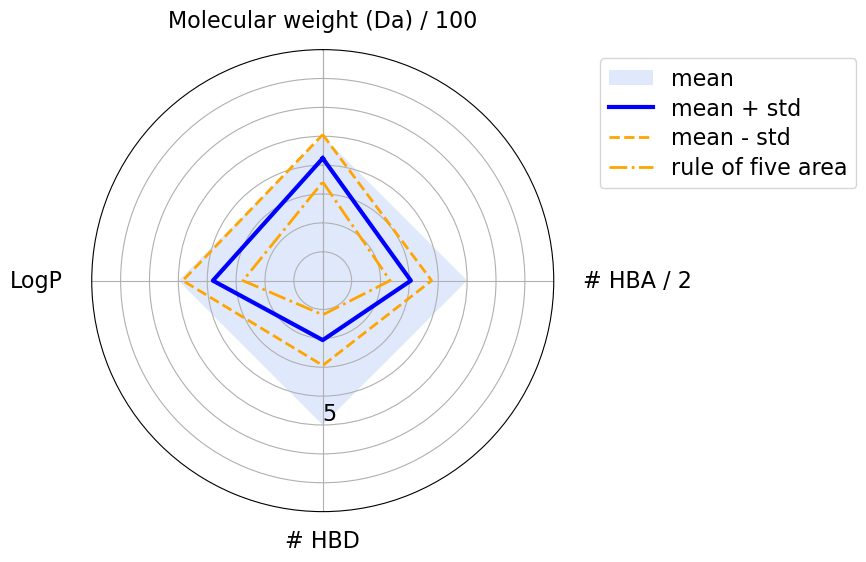

In [69]:
plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

**Plot the radarplot for the dataset of compounds that violate the Ro5.**

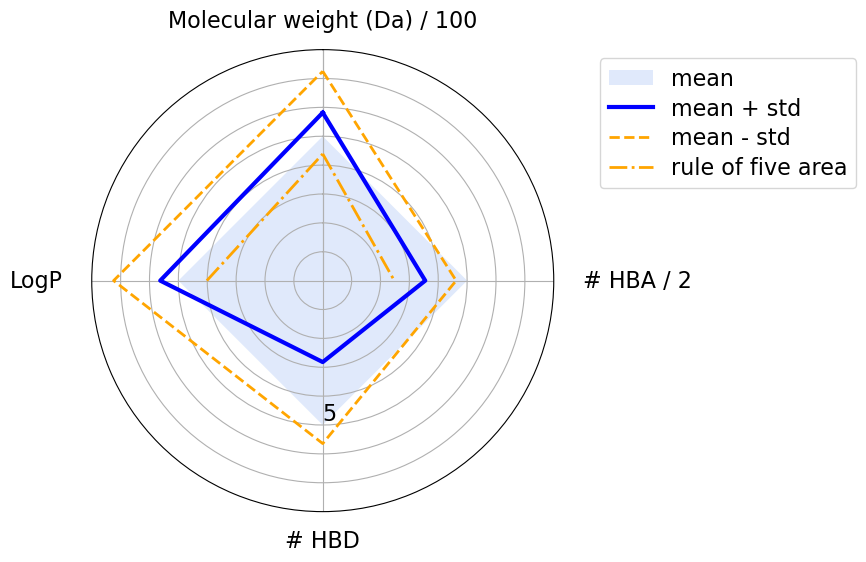

In [70]:
plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

**NOTE:** We have plotted HBA/2 and HBD for scaling

## **FILTERING UNWANTED STRUCTURES**

In [71]:
ret_data = pd.read_csv("RET_compounds_lipinski.csv")
ret_data.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL2347725,0.015,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909,425.188546,6,2,3.3408,True
1,CHEMBL2347722,0.021,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781,412.156912,6,2,3.4256,True
2,CHEMBL2347723,0.064,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820,343.099062,5,3,3.0857,True
3,CHEMBL2347711,0.064,nM,CCNC(=O)Nc1nc2ccc(-c3ccccc3OCC)cc2s1,10.193820,341.119798,4,2,4.5034,True
4,CHEMBL2347719,0.110,nM,CCNC(=O)Nc1nc2ccc(-c3ccc(N)cc3OC)cc2s1,9.958607,342.115047,5,3,3.6955,True


In [72]:
print("Dataframe shape:", ret_data.shape)
ret_data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
ret_data.head()

Dataframe shape: (1251, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,ro5_fulfilled
0,CHEMBL2347725,0.015,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909,True
1,CHEMBL2347722,0.021,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781,True
2,CHEMBL2347723,0.064,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820,True
3,CHEMBL2347711,0.064,nM,CCNC(=O)Nc1nc2ccc(-c3ccccc3OCC)cc2s1,10.193820,True
4,CHEMBL2347719,0.110,nM,CCNC(=O)Nc1nc2ccc(-c3ccc(N)cc3OC)cc2s1,9.958607,True


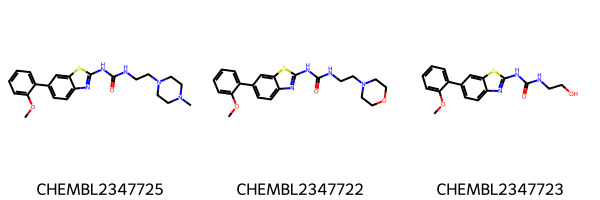

In [73]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(ret_data, smilesCol="smiles")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(ret_data.head(3).ROMol),
    legends=list(ret_data.head(3).molecule_chembl_id),
)

## 3. PAINS Removal

Pan-Assay Interference Compounds (PAINS) are excluded to reduce false positives during screening.


**FILTER FOR PAINS**

In [74]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [75]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(ret_data.iterrows(), total=ret_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
ret_data = ret_data.loc[clean]  # keep molecules without PAINS


  0%|          | 0/1251 [00:00<?, ?it/s]

In [76]:
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(ret_data)}")

Number of compounds with PAINS: 24
Number of compounds without PAINS: 1227


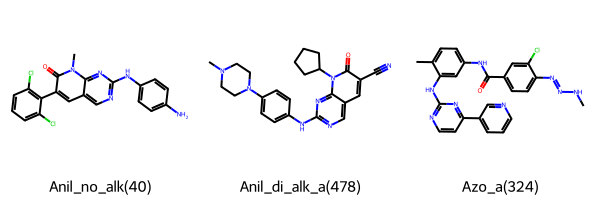

In [77]:
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    legends=list(matches.head(3)["pains"]),
)

**FILTER AND HIGHLIGHT UNWANTED SUBSTRUCTURES**

In [78]:
substructures = pd.read_csv("Unwanted_Structures.csv")
substructures["rdkit_molecule"] = substructures.smiles.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))

Number of unwanted substructures in collection: 105


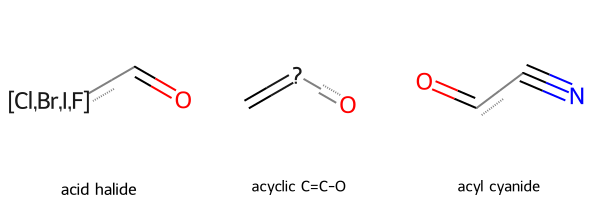

In [79]:
Chem.Draw.MolsToGridImage(
    mols=substructures.rdkit_molecule.tolist()[2:5],
    legends=substructures.name.tolist()[2:5],
)

List used from the literature: 
https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139

In [80]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(ret_data.iterrows(), total=ret_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "chembl_id": row.molecule_chembl_id,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
ret_data = ret_data.loc[clean]

  0%|          | 0/1227 [00:00<?, ?it/s]

In [81]:
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(ret_data)}")

Number of found unwanted substructure: 483
Number of compounds without unwanted substructure: 823


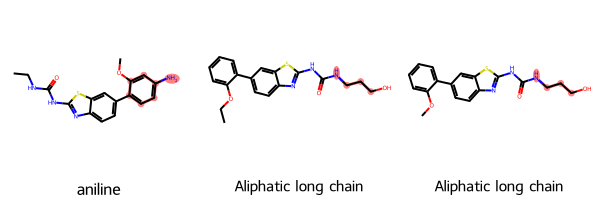

In [82]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(3).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(3).substructure_name),
)


In [83]:
groups = matches.groupby("substructure_name")
group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies.head(10)

substructure_name
alkyl halide                    135
triple bond                     111
Aliphatic long chain             36
Michael acceptor                 35
Oxygen-nitrogen single bond      29
phosphor                         29
2-halo pyridine                  23
aniline                          18
imine                            12
perfluorinated chain             10
dtype: int64

## **COMPOUND SIMILARITY**


**Practice: Import and draw molecules**

In [84]:
molecule_smiles = [
    "CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O",
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C",
    "C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl",
    "CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC",
    "C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl",
    "CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C",
    "CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O",
    "CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O",
]

# List of molecule names
molecule_names = [
    "Doxycycline",
    "Amoxicilline",
    "Furosemide",
    "Glycol dilaurate",
    "Hydrochlorothiazide",
    "Isotretinoin",
    "Tetracycline",
    "Hemi-cycline D",
]

,smiles,name,ROMol
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,

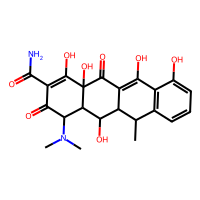
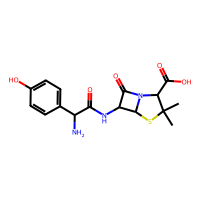

In [85]:
molecules = pd.DataFrame({"smiles": molecule_smiles, "name":molecule_names})
PandasTools.AddMoleculeColumnToFrame(molecules, smilesCol="smiles") 
PandasTools.RenderImagesInAllDataFrames(True)
# Show first 2 molecules
molecules.head(2)

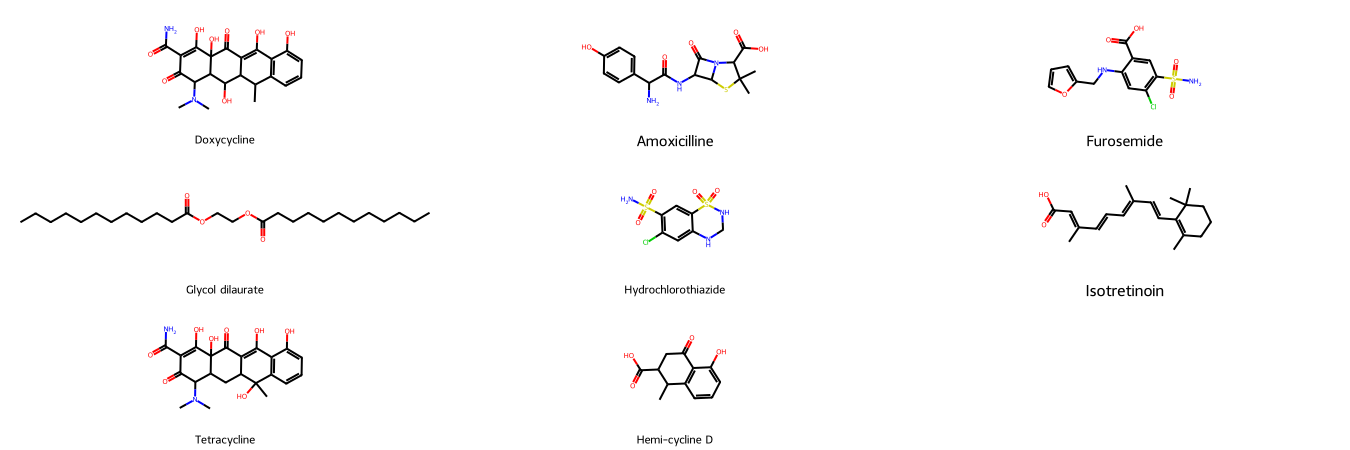

In [86]:
Draw.MolsToGridImage(
    molecules["ROMol"].to_list(),
    molsPerRow=3,
    subImgSize=(450, 150),
    legends=molecules["name"].to_list(),
)

**Calculate molecular descriptors**

**1D molecular descriptors: Molecular weight**

In [87]:
molecules["molecule_weight"] = molecules.ROMol.apply(Descriptors.MolWt)
molecules.sort_values(["molecule_weight"], ascending=False, inplace=True)

In [88]:
molecules[["smiles", "name", "molecule_weight"]]

,smiles,name,molecule_weight
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,444.440
6,CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Tetracycline,444.440
3,CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC,Glycol dilaurate,426.682
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,365.411
2,C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl,Furosemide,330.749
5,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,Isotretinoin,300.442
4,C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl,Hydrochlorothiazide,297.745
7,CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O,Hemi-cycline D,220.224


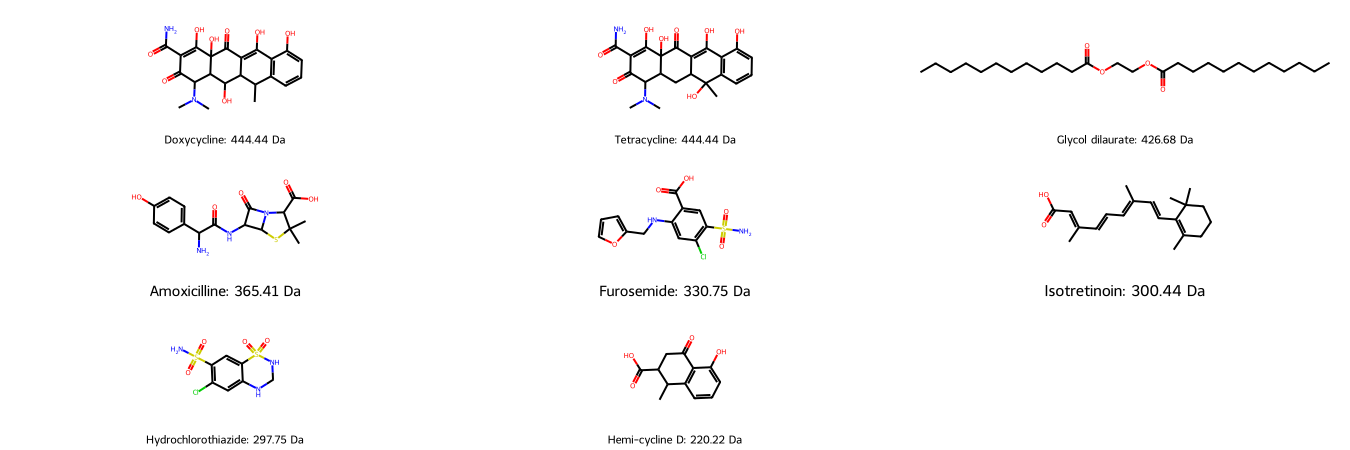

In [89]:
# Draw molecules with their molecular weight

Draw.MolsToGridImage(
    molecules["ROMol"],
    legends=[
        f"{molecule['name']}: {molecule['molecule_weight']:.2f} Da" for index, molecule in molecules.iterrows()
    ],
    subImgSize=(450, 150),
    molsPerRow=3,
)

As we can see, molecules with similar molecular weight can have a similar structure (e.g. Doxycycline/Tetracycline), however they can also have a similar number of atoms in completely different arrangements (e.g. Doxycycline/Glycol dilaurate orHydrochlorothiazide/Isotretinoin).

In order to account for more detailed properties of a molecule, we now take a look at 2D molecular descriptors.

## 4. Molecular Fingerprint Generation

Structural similarity is computed using:
- MACCS keys
- Morgan fingerprints (radius = 2, 2048 bits)

Fingerprints provide vector representations of molecular structure.


**2D molecular descriptors: MACCS fingerprint**

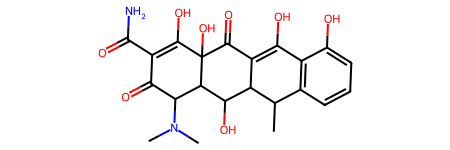

In [90]:
# EXAMPLE
molecule = molecules["ROMol"][0]
molecule

In [91]:
# MACCS finngerprints
maccs_fp = MACCSkeys.GenMACCSKeys(molecule)

In [92]:
maccs_fp.ToBitString() # As explicit bitvectors are not human-readable, we will further transform them to bitstrings.

'00000000000000000000000000100000000000000000000000100110000000000010000010101000000011100100110101010100010000101100010000100001000101001001111111101111101011111111110'

In [93]:
# Add MACCS 9ngerprints for all molecules to the DataFrame.

molecules["maccs"] = molecules.ROMol.apply(MACCSkeys.GenMACCSKeys)

**2D molecular descriptors: Morgan fingerprints**

In [94]:
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
circular_int_fp = fpg.GetCountFingerprint(molecule)
circular_int_fp

In [95]:
print(f"Print non-zero elements:\n{circular_int_fp.GetNonzeroElements()}")


Print non-zero elements:
{45: 1, 118: 1, 140: 1, 163: 1, 276: 1, 303: 1, 309: 1, 314: 2, 371: 1, 438: 1, 525: 1, 557: 1, 650: 3, 673: 1, 699: 1, 807: 6, 824: 1, 829: 1, 881: 1, 1009: 1, 1019: 5, 1027: 1, 1039: 1, 1057: 3, 1060: 1, 1061: 1, 1070: 1, 1082: 1, 1088: 1, 1119: 1, 1154: 1, 1163: 2, 1171: 1, 1257: 1, 1296: 1, 1309: 1, 1341: 1, 1380: 9, 1389: 1, 1457: 1, 1471: 1, 1487: 1, 1582: 1, 1602: 3, 1607: 1, 1630: 1, 1747: 1, 1750: 2, 1831: 1, 1833: 1, 1857: 1, 1873: 3, 1917: 1, 1932: 1, 2000: 1, 2029: 1}


In [96]:
# Generate the Morgan 9ngerprint as bit vector.
circular_bit_fp = fpg.GetFingerprint(molecule)
circular_bit_fp

In [97]:
print(f"Print top 400 fingerprint bits:\n{circular_bit_fp.ToBitString() [:400]}")

Print top 400 fingerprint bits:
0000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000010000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000001000001000010000000000000000000000000000000000000000000000000000000010000000000000000000000000000


In [98]:
# Add Morgan 9ngerprints (as bit vector) for all molecules to the DataFrame.
molecules["morgan"] = molecules["ROMol"].map(fpg.GetFingerprint)

**Calculate molecular similarity by applying Tanimoto and Dice Similarities**

In [99]:
# Example molecule pair: Compare two MACCS 9ngerprints with the Tanimoto similarity.
# Example molecules
molecule1 = molecules["ROMol"][0]
molecule2 = molecules["ROMol"][1]
# Example fingerprints
maccs_fp1 = MACCSkeys.GenMACCSKeys(molecule1)
maccs_fp2 = MACCSkeys.GenMACCSKeys(molecule2)

In [100]:
# Calculate Tanimoto coefficient between two different molecules

DataStructs.TanimotoSimilarity(maccs_fp1, maccs_fp2)

0.5909090909090909

In [101]:
# Calculate Tanimoto coefficient between the same molecule.
DataStructs.TanimotoSimilarity(maccs_fp1, maccs_fp1)

1.0

**MACCS fingerprints: Tanimoto similarity and Dice similarity**

Add the Tanimoto and Dice similarities between MACCS 9ngerprints to the DataFrame.

In [102]:
# Define molecule query and list
molecule_query = molecules["maccs"][0]
molecule_list = molecules["maccs"].to_list()
# Calculate similarty values between query and list elements
molecules["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecules["dice_maccs"] = DataStructs.BulkDiceSimilarity(molecule_query,
molecule_list)


In [103]:
"""
Sort the DataFrame by the Tanimoto similarity of the MACCS fingerprints (show only name and 
similarity columns!).
"""
preview = molecules.sort_values(["tanimoto_maccs"], ascending=False).reset_index()
preview[["name", "tanimoto_maccs", "dice_maccs"]]

,name,tanimoto_maccs,dice_maccs
0,Doxycycline,1.000000,1.000000
1,Tetracycline,0.928571,0.962963
2,Amoxicilline,0.590909,0.742857
3,Hemi-cycline D,0.403509,0.575000
4,Furosemide,0.321839,0.486957
5,Hydrochlorothiazide,0.306818,0.469565
6,Isotretinoin,0.288136,0.447368
7,Glycol dilaurate,0.149254,0.259740


Note: Dice similarity values are greater than Tanimoto similarity values

## 5. Similarity Ranking

Dasatinib is used as a reference ligand.

Compounds are ranked based on Tanimoto and Dice similarity.


**Draw molecules ranked by the Tanimoto similarity of MACCS fingerprints.**

In [104]:
def draw_ranked_molecules(molecules, sort_by_column):
    """
    Draw molecules sorted by a given column.
    Parameters
    ----------
    molecules : pandas.DataFrame
    Molecules (with "ROMol" and "name" columns and a column to sort by.
    sort_by_column : str
    Name of the column used to sort the molecules by.
    Returns
    -------
    Draw.MolsToGridImage
    2D visualization of sorted molecules.
    """
    molecules_sorted = molecules.sort_values([sort_by_column], ascending=False).reset_index()
    return Draw.MolsToGridImage(
        molecules_sorted["ROMol"], legends=[
            f"#{index+1} {molecule['name']},  similarity= {molecule[sort_by_column]:.2f}"
            for index, molecule in molecules_sorted.iterrows() ],
              molsPerRow=3,
              subImgSize=(450, 150),
          )


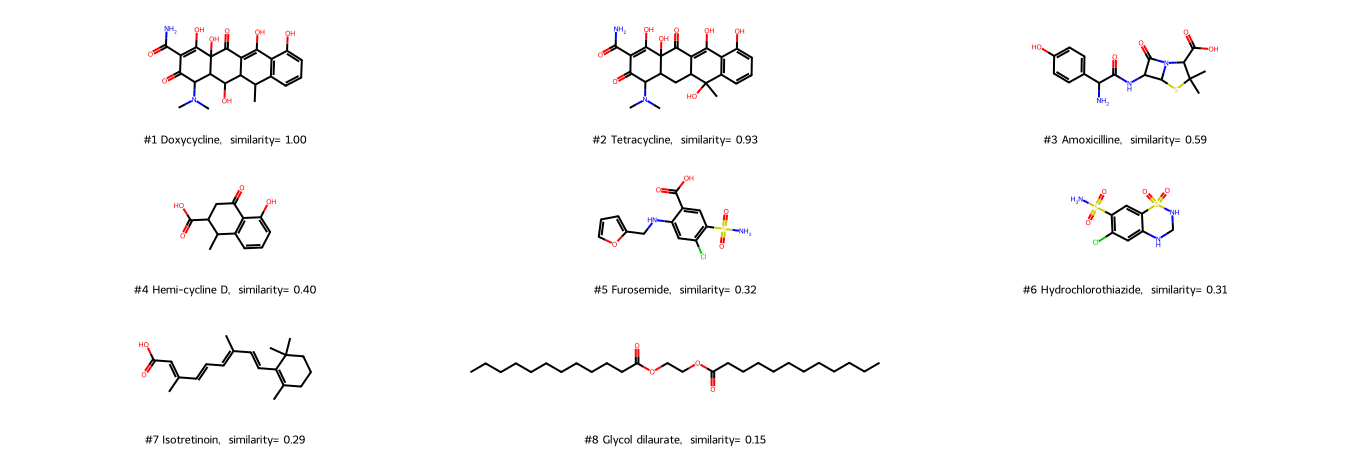

In [105]:
draw_ranked_molecules(molecules, "tanimoto_maccs")

**Note:**

With MACCS 9ngerprints, Tetracycline is the most similar molecule (high score), followed by Amoxicilline. In contrast to the 1D descriptor molecular weight, the linear molecule Glycol dilaurate is recognized as dissimilar (last rank).

**Morgan fingerprints: Tanimoto similarity and Dice similarity**

In [106]:
# Add the Tanimoto and Dice similarities between the Morgan 9ngerprints to the DataFrame.
molecule_query = molecules["morgan"][0]
molecule_list = molecules["morgan"].to_list()
molecules["tanimoto_morgan"] =DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecules["dice_morgan"] = DataStructs.BulkDiceSimilarity(molecule_query,molecule_list)

In [107]:
# Sort the DataFrame by the Tanimoto similarity of the Morgan Fingerprints.
preview = molecules.sort_values(["tanimoto_morgan"], ascending=False).reset_index()
preview[["name", "tanimoto_morgan", "dice_morgan", "tanimoto_maccs", "dice_maccs"]]

,name,tanimoto_morgan,dice_morgan,tanimoto_maccs,dice_maccs
0,Doxycycline,1.000000,1.000000,1.000000,1.000000
1,Tetracycline,0.534247,0.696429,0.928571,0.962963
2,Hemi-cycline D,0.308824,0.471910,0.403509,0.575000
3,Amoxicilline,0.144444,0.252427,0.590909,0.742857
4,Furosemide,0.098901,0.180000,0.321839,0.486957
5,Isotretinoin,0.067416,0.126316,0.288136,0.447368
6,Hydrochlorothiazide,0.058824,0.111111,0.306818,0.469565
7,Glycol dilaurate,0.054795,0.103896,0.149254,0.259740


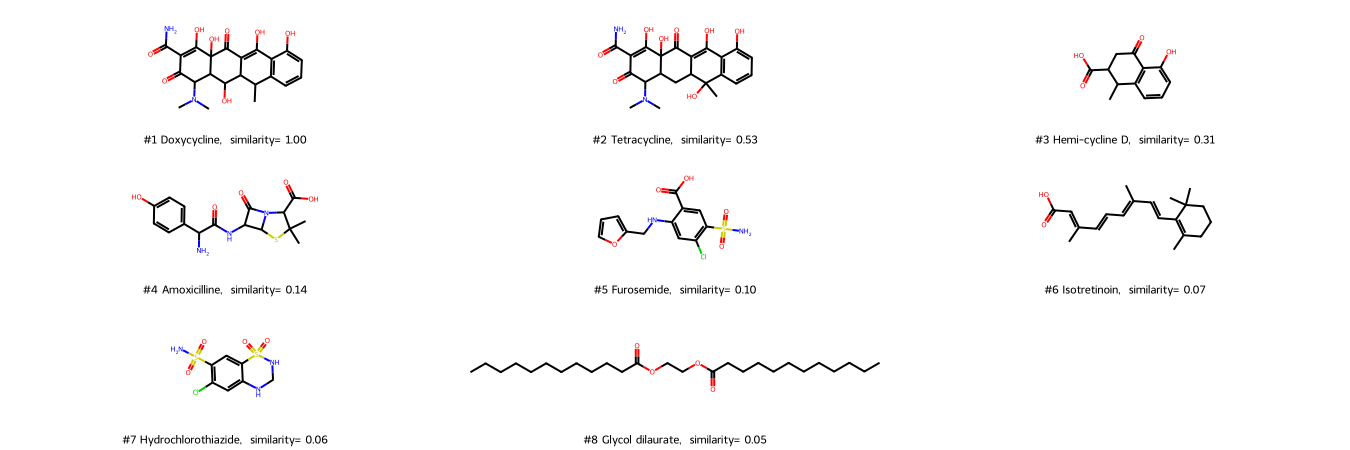

In [108]:
# Draw molecules ranked by the Tanimoto similarities of Morgan Fingerprints.
draw_ranked_molecules(molecules, "tanimoto_morgan")

**Now, to compare Tanimoto Similarities based on MACCS and Morgan Fingerprints, we can plot Tanimoto similarities based on Morgan VS MACCS fingerprints.**

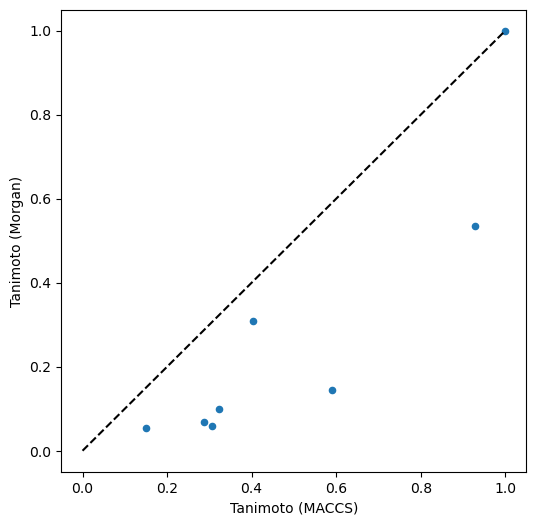

In [109]:
fig, ax = plt.subplots(figsize=(6, 6))
molecules.plot("tanimoto_maccs", "tanimoto_morgan", kind="scatter", ax=ax)
ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("Tanimoto (MACCS)")
ax.set_ylabel("Tanimoto (Morgan)")
fig;

**NOW, WE CAN PERFORM SIMILARITY SEARCH OF A QUERY MOLECULE AGAINST A FULL DATASET OF MOLECULES**

In [110]:
# Import molecules from CSV file RET_compounds_lipinski.csv
molecule_dataset = pd.read_csv("RET_compounds_lipinski.csv")
print(f"Number of molecules in the dataset: {len(molecule_dataset)}")
molecule_dataset.head(5)

Number of molecules in the dataset: 1251


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL2347725,0.015,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909,425.188546,6,2,3.3408,True
1,CHEMBL2347722,0.021,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781,412.156912,6,2,3.4256,True
2,CHEMBL2347723,0.064,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820,343.099062,5,3,3.0857,True
3,CHEMBL2347711,0.064,nM,CCNC(=O)Nc1nc2ccc(-c3ccccc3OCC)cc2s1,10.193820,341.119798,4,2,4.5034,True
4,CHEMBL2347719,0.110,nM,CCNC(=O)Nc1nc2ccc(-c3ccc(N)cc3OC)cc2s1,9.958607,342.115047,5,3,3.6955,True


**Set Query Molecule: Dasatinib**

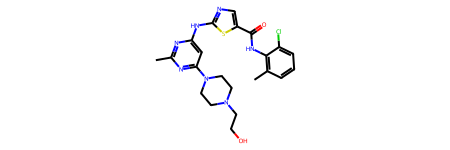

In [111]:
# Generate ROMol object from Dasatinib's SMILES
smiles = "Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CCO)CC2)n1"
query = Chem.MolFromSmiles(smiles)
query

In [112]:
# Generate MACCS and Morgan 9ngerprints for the query molecule.
maccs_fp_query = MACCSkeys.GenMACCSKeys(query)
circular_fp_query = fpg.GetCountFingerprint(query)

In [113]:
# Generate MACCS and Morgan fingerprints for all molecules in the dataset
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles")
circular_fp_list = molecule_dataset["ROMol"].apply(fpg.GetCountFingerprint).tolist()
maccs_fp_list = molecule_dataset["ROMol"].apply(MACCSkeys.GenMACCSKeys).tolist()

**Calculate Tanimoto Similarity between Sepercatinib and all molecules in the dataset molecule_dataset**

In [114]:
molecule_dataset["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(maccs_fp_query, maccs_fp_list)
molecule_dataset["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(circular_fp_query, circular_fp_list)

**Calculate Dice Similarity between Sepercatinib and all molecules in the dataset molecule_dataset**

In [115]:
molecule_dataset["dice_maccs"] = DataStructs.BulkDiceSimilarity(maccs_fp_query, maccs_fp_list)
molecule_dataset["dice_morgan"] = DataStructs.BulkDiceSimilarity(circular_fp_query, circular_fp_list)

In [116]:
molecule_dataset[["smiles", "tanimoto_maccs", "tanimoto_morgan", "dice_maccs","dice_morgan"]]

,smiles,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,0.712500,0.330882,0.832117,0.497238
1,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,0.737500,0.278571,0.848921,0.435754
2,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,0.637500,0.244275,0.778626,0.392638
3,CCNC(=O)Nc1nc2ccc(-c3ccccc3OCC)cc2s1,0.564103,0.234848,0.721311,0.380368
4,CCNC(=O)Nc1nc2ccc(-c3ccc(N)cc3OC)cc2s1,0.525000,0.218045,0.688525,0.358025
...,...,...,...,...,...
1246,O=c1c2cnn(-c3ccccc3)c2n2c(Nc3ccccc3)nnc2n1-c1c...,0.480519,0.159509,0.649123,0.275132
1247,Cc1ccc(C(=O)Nc2cc(C(F)(F)F)ccc2F)cc1/C=C/n1cnc...,0.573333,0.203704,0.728814,0.338462
1248,Cc1ccc(C(=O)Nc2ncc(C(C)(C)C)s2)cc1/C=C/n1cnc2c...,0.597403,0.258278,0.747967,0.410526
1249,Nc1ncnc2[nH]c(C(F)(F)F)nc12,0.356164,0.090909,0.525253,0.166667


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,CHEMBL2347725,0.015,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909,425.188546,6,2,3.3408,True,,0.7125,0.330882,0.832117,0.497238
1,CHEMBL2347722,0.021,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781,412.156912,6,2,3.4256,True,,0.7375,0.278571,0.848921,0.435754
2,CHEMBL2347723,0.064,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820,343.099062,5,3,3.0857,True,,0.6375,0.244275,0.778626,0.392638

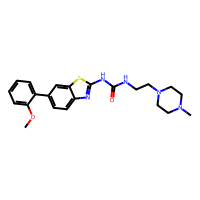
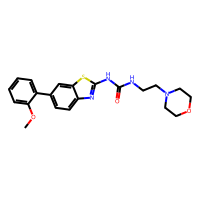
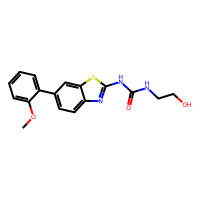

In [117]:
molecule_dataset.head(3)

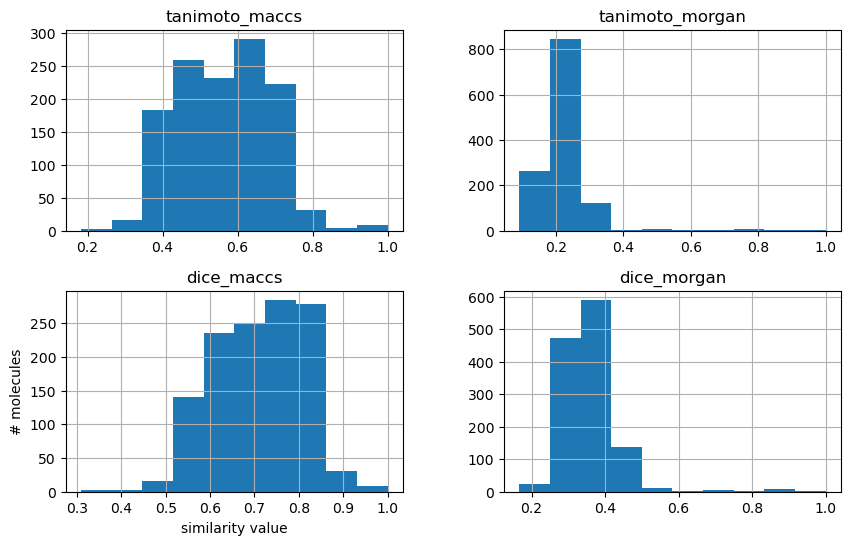

In [118]:
# Plot distribution of Tanimoto similarity of MACCS fingerprints
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
molecule_dataset.hist(["tanimoto_maccs"], ax=axes[0, 0])
molecule_dataset.hist(["tanimoto_morgan"], ax=axes[0, 1])
molecule_dataset.hist(["dice_maccs"], ax=axes[1, 0])
molecule_dataset.hist(["dice_morgan"], ax=axes[1, 1])
axes[1, 0].set_xlabel("similarity value")
axes[1, 0].set_ylabel("# molecules")
fig;

Text(0, 0.5, 'Dice (Morgan)')

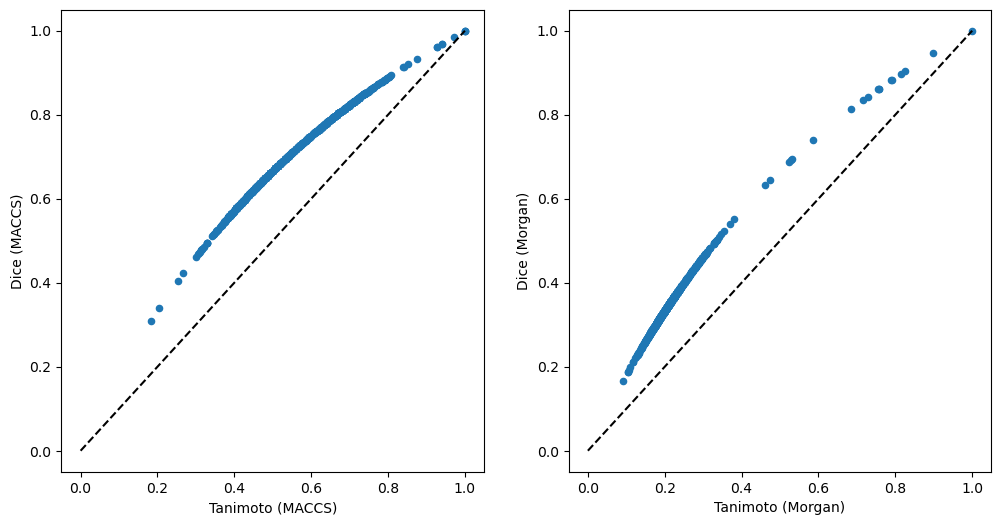

In [119]:
fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
molecule_dataset.plot("tanimoto_maccs", "dice_maccs", kind="scatter",
ax=axes[0])
axes[0].plot([0, 1], [0, 1], "k--")
axes[0].set_xlabel("Tanimoto (MACCS)")
axes[0].set_ylabel("Dice (MACCS)")
molecule_dataset.plot("tanimoto_morgan", "dice_morgan", kind="scatter",
ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_xlabel("Tanimoto (Morgan)")
axes[1].set_ylabel("Dice (Morgan)")

**Visualize most similar molecules**

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
340,CHEMBL1421,4.2,nM,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,8.376751,487.155722,9,3,3.31354,True,,1.000000,1.000000,1.000000,1.000000
479,CHEMBL240158,9.1,nM,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,8.040959,489.151385,8,2,4.29074,True,,0.852941,0.898990,0.920635,0.946809
561,CHEMBL4869199,17.7,nM,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cncc3Cl)s2)cc(N2CCN(C...,7.752027,488.150971,10,3,2.70854,True,,1.000000,0.825243,1.000000,0.904255

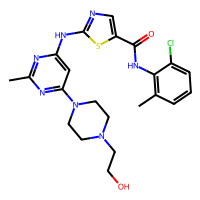
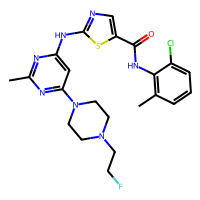
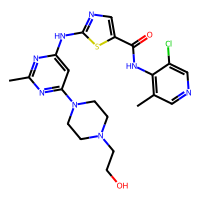

In [120]:
molecule_dataset.sort_values(["tanimoto_morgan"], ascending=False).head(3)

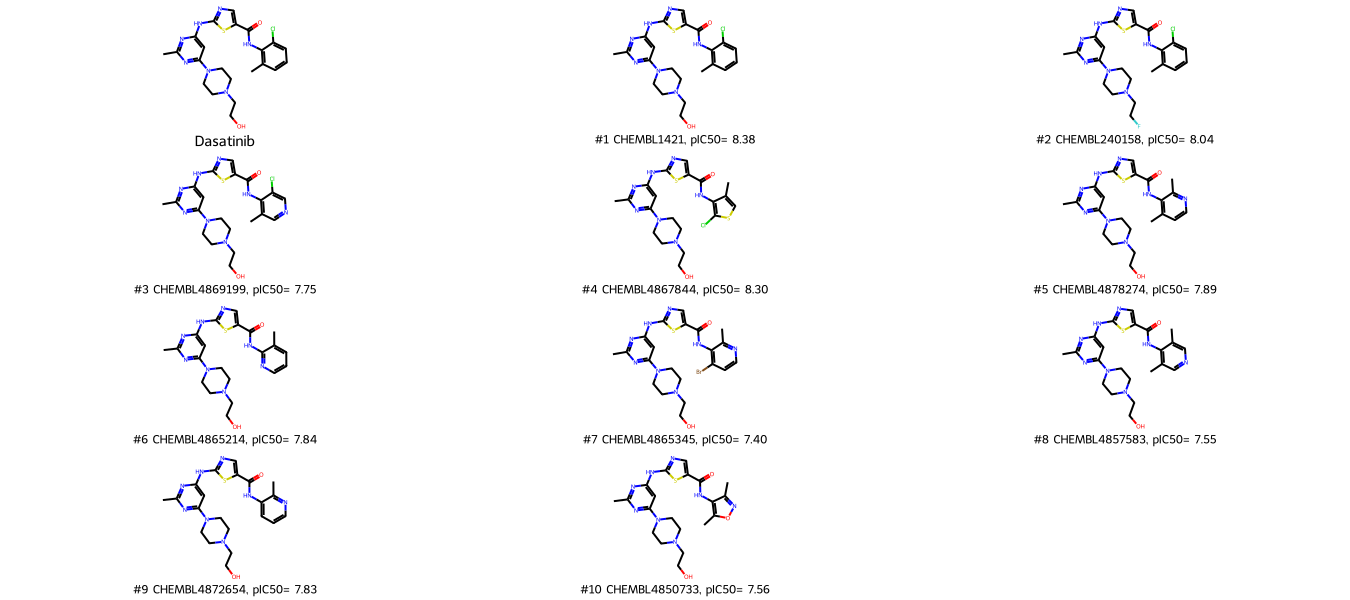

In [121]:
top_n_molecules = 10
top_molecules = molecule_dataset.sort_values(["tanimoto_morgan"], ascending=False).reset_index()
top_molecules = top_molecules[:top_n_molecules]
legends = [
f"#{index+1} {molecule['molecule_chembl_id']}, pIC50= {molecule['pIC50']:.2f}"
for index, molecule in top_molecules.iterrows() 
]
Chem.Draw.MolsToGridImage(
    mols=[query] + top_molecules["ROMol"].tolist(),
    legends=(["Dasatinib"] + legends),
    molsPerRow=3,
    subImgSize=(450, 150),
)

## 6. Enrichment Analysis

Screening performance is evaluated using enrichment curves.

Active threshold: pIC50 > 6.3


**Enrichment Plots**

Enrichment plots show
-the ratio of top-ranked molecules (x-axis) from the whole dataset vs. 

-the ratio of active molecules (y-axis) from the whole dataset.

We compare the Tanimoto similarity for MACCS and Morgan 9ngerprints.

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,CHEMBL2347725,0.015,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909,425.188546,6,2,3.3408,True,,0.7125,0.330882,0.832117,0.497238
1,CHEMBL2347722,0.021,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781,412.156912,6,2,3.4256,True,,0.7375,0.278571,0.848921,0.435754
2,CHEMBL2347723,0.064,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820,343.099062,5,3,3.0857,True,,0.6375,0.244275,0.778626,0.392638

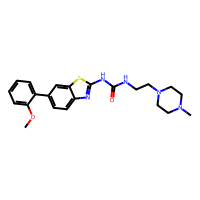
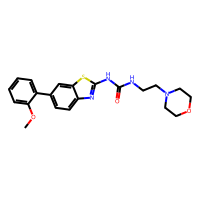
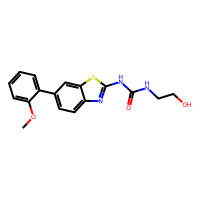

In [122]:
molecule_dataset.head(3)

**CALCULATION OF ENRICHMENT DATA**

In [ ]:
def get_enrichment_data(molecules, similarity_measure, pic50_cutoff):
    """
    Calculates x and y values for enrichment plot:
    x - % ranked dataset
    y - % true actives identified
    Parameters
    ----------
    molecules : pandas.DataFrame
    Molecules with similarity values to a query molecule.
    similarity_measure : str
    Column name which will be used to sort the DataFrame.
    pic50_cutoff : float
    pIC50 cutoff value used to discriminate active and inactive
    molecules.
    Returns
    -------
    pandas.DataFrame
    Enrichment data: Percentage of ranked dataset by similarity vs.
    percentage of identified true actives.
    """


    # Get number of molecules in data set
    molecules_all = len(molecules)
    # Get number of active molecules in data set
    actives_all = sum(molecules["pIC50"] >= pic50_cutoff)
    actives_counter_list = []
    # Initialize counter for actives
    actives_counter = 0
# Sort molecules by selected similarity measure 
    molecules.sort_values([similarity_measure], ascending=False, inplace=True)
    # Iterate over the ranked dataset and check each molecule if active (by checking bioactivity)
    for value in molecules["pIC50"]: 
        if value >= pic50_cutoff:
            actives_counter += 1
        actives_counter_list.append(actives_counter)
    # Transform number of molecules into % ranked dataset
    molecules_percentage_list = [i / molecules_all for i in range(1, molecules_all + 1)]
    # Transform number of actives into % true actives identified
    actives_percentage_list = [i / actives_all for i in actives_counter_list]
    # Generate DataFrame with x and y values as well as label
    enrichment = pd.DataFrame({"% ranked dataset": molecules_percentage_list,"% true actives identified": actives_percentage_list,})
    return enrichment


In [124]:
pic50_cutoff = 6.3

In [125]:
similarity_measures = ["tanimoto_maccs", "tanimoto_morgan"]
enrichment_data = {similarity_measure: get_enrichment_data(molecule_dataset,similarity_measure, pic50_cutoff)
for similarity_measure in similarity_measures}

In [126]:
enrichment_data["tanimoto_maccs"].head()

,% ranked dataset,% true actives identified
0,0.000799,0.001140
1,0.001599,0.002281
2,0.002398,0.003421
3,0.003197,0.004561
4,0.003997,0.005701


**ENRICHMENT PLOT**

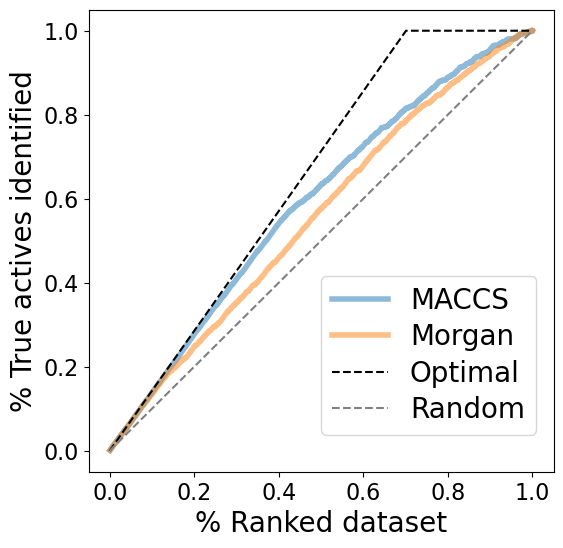

In [127]:
fig, ax = plt.subplots(figsize=(6, 6))
fontsize = 20
# Plot enrichment data
for similarity_measure, enrichment in enrichment_data.items(): 
    ax = enrichment.plot(
        ax=ax,
        x="% ranked dataset",
        y="% true actives identified", label=similarity_measure, alpha=0.5,
        linewidth=4,
    )
ax.set_ylabel("% True actives identified", size=fontsize)
ax.set_xlabel("% Ranked dataset", size=fontsize)
# Plot optimal curve: Ratio of actives in dataset
ratio_actives = sum(molecule_dataset["pIC50"] >= pic50_cutoff) / len(molecule_dataset)
ax.plot(
    [0, ratio_actives, 1],
    [0, 1, 1],
    label="Optimal curve",
    color="black",
    linestyle="--",
)
# Plot random curve
ax.plot([0, 1], [0, 1], label="Random curve", color="grey", linestyle="--")
plt.tick_params(labelsize=16)
plt.legend(
    labels=["MACCS", "Morgan", "Optimal", "Random"],
    loc=(0.5, 0.08),
    fontsize=fontsize,
    labelspacing=0.3,
)
plt.show()


**Regression Analysis on the Enrichment plot**

/var/folders/07/bf0kkx6s1tvfkm1xklx1ffh00000gn/T/ipykernel_989/576447042.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(df_Morgan["% ranked dataset"], df_Morgan["% true actives identified"], 'r-', label='Morgan', alpha=0.5, color = "orange", linewidth = 3)


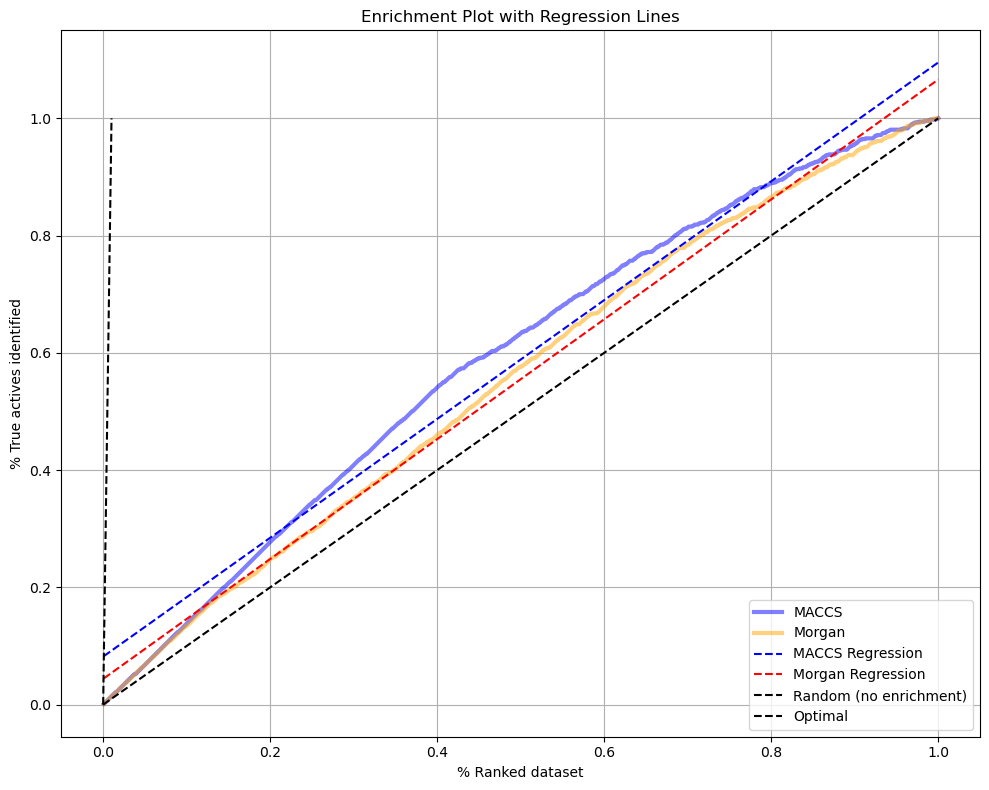

In [128]:
def get_enrichment_data(molecules, similarity_measure, pic50_cutoff):
    molecules_all = len(molecules)
    actives_all = sum(molecules["pIC50"] >= pic50_cutoff)
    actives_counter_list = []
    actives_counter = 0
    molecules.sort_values(by=[similarity_measure], ascending=False, inplace=True)
    for value in molecules["pIC50"]:
        if value >= pic50_cutoff:
            actives_counter += 1
        actives_counter_list.append(actives_counter)
    molecules_percentage_list = [i / molecules_all for i in range(1, molecules_all + 1)]
    actives_percentage_list = [i / actives_all for i in actives_counter_list]
    enrichment = pd.DataFrame({
        "% ranked dataset": molecules_percentage_list,
        "% true actives identified": actives_percentage_list
    })
    return enrichment

# Define pIC50 cutoff
pic50_cutoff = 6.3

# Calculate enrichment data for MACCS and Morgan
df_MACCS = get_enrichment_data(molecule_dataset, 'tanimoto_maccs', pic50_cutoff)
df_Morgan = get_enrichment_data(molecule_dataset, 'tanimoto_morgan', pic50_cutoff)

# Perform linear regression
slope_MACCS, intercept_MACCS, _, _, _ = linregress(df_MACCS["% ranked dataset"], df_MACCS["% true actives identified"])
slope_Morgan, intercept_Morgan, _, _, _ = linregress(df_Morgan["% ranked dataset"], df_Morgan["% true actives identified"])

# Create the plot
plt.figure(figsize=(10, 8))

# Plot the enrichment data
plt.plot(df_MACCS["% ranked dataset"], df_MACCS["% true actives identified"], 'b-', label='MACCS', linewidth = 3, alpha=0.5)
plt.plot(df_Morgan["% ranked dataset"], df_Morgan["% true actives identified"], 'r-', label='Morgan', alpha=0.5, color = "orange", linewidth = 3)

# Plot the regression lines
plt.plot(df_MACCS["% ranked dataset"], intercept_MACCS + slope_MACCS * df_MACCS["% ranked dataset"], 'b--', label='MACCS Regression')
plt.plot(df_Morgan["% ranked dataset"], intercept_Morgan + slope_Morgan * df_Morgan["% ranked dataset"], 'r--', label='Morgan Regression')

# Plot the Random line
plt.plot([0, 1], [0, 1], 'k--', label='Random (no enrichment)')

# It will start at (0,0) and go to a point very close to (0,1) on the x-axis
plt.plot([0, 0.01], [0, 1], 'k--', label='Optimal')

# Add plot labels, legend, and title
plt.xlabel('% Ranked dataset')
plt.ylabel('% True actives identified')
plt.title('Enrichment Plot with Regression Lines')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


Molecules are sorted in descending order based on a similarity measure. This means that molecules most similar to a reference (e.g., a known active compound) are at the top of the list. A molecule is considered active if its pIC50 value is above a certain cutoff (which is a parameter of the function).

**Calculating the Percentage of the Ranked Dataset:**

This is the x-axis of the enrichment plot. It represents the fraction of the dataset that has been considered up to each point in the ranked list. It is calculated by taking the rank of each molecule and dividing by the total number of molecules.

**Calculating the Percentage of True Actives Identified:**

This is the y-axis of the enrichment plot. For every point in the ranked list, we calculate the proportion of active molecules identified out of the total number of actives. We do this by maintaining a counter that increases each time an active molecule is encountered as we iterate through your sorted list.

To determine which method is better, we compare how close each line is to the 'Optimal' line and how far away they are from the 'Random' line:

If a line is closer to the 'Optimal' line, it suggests that the ranking method it represents is more effective at identifying active molecules early in the ranking.
If a line is closer to the 'Random' line, it indicates that the method is not much better than random chance at identifying active molecules.
In your case, the lines for both MACCS and Morgan are quite close together, suggesting that both methods have similar effectiveness in ranking the active molecules. Hence to analyse it better, we use Regreesion analysis which shows that MACCS outperforms Morgan fingerprints.

# **RECOMMENDATIONS**

**Area Under the Curve (AUC):**

Calculate the AUC for each enrichment curve. The AUC provides a single measure of the overall performance of the fingerprinting method across the entire range of the dataset. A higher AUC would indicate a better performance. Comparing AUCs can help determine which method is more effective overall.

**Enrichment Factor (EF):**

Calculate the enrichment factor at various percentages of the screened dataset. The EF is the ratio of the percentage of true actives identified to the percentage of the dataset screened. Comparing EFs at early percentages (e.g., 1%, 5%, 10%) can highlight which method provides better early enrichment.

**Calculate Enrichment Factors**

In [129]:
def calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff):
    """
    Get the experimental enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    enrichment : pd.DataFrame
        Enrichment data: Percentage of ranked dataset by similarity vs. percentage of
        identified true actives.
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.

    Returns
    -------
    float
        Experimental enrichment factor.
    """

    # Keep only molecules that meet the cutoff
    enrichment = enrichment[
        enrichment["% ranked dataset"] <= ranked_dataset_percentage_cutoff / 100
    ]
    # Get highest percentage of actives and the corresponding percentage of actives
    highest_enrichment = enrichment.iloc[-1]
    enrichment_factor = round(100 * float(highest_enrichment["% true actives identified"]), 1)
    return enrichment_factor

In [130]:
def calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff):
    """
    Get the random enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.

    Returns
    -------
    float
        Random enrichment factor.
    """

    enrichment_factor_random = round(float(ranked_dataset_percentage_cutoff), 1)
    return enrichment_factor_random

In [131]:
def calculate_enrichment_factor_optimal(molecules, ranked_dataset_percentage_cutoff, pic50_cutoff):
    """
    Get the optimal random enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    molecules : pandas.DataFrame
        the DataFrame with all the molecules and pIC50.
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.
    activity_cutoff: float
        pIC50 cutoff value used to discriminate active and inactive molecules

    Returns
    -------
    float
        Optimal enrichment factor.
    """

    ratio = sum(molecules["pIC50"] >= pic50_cutoff) / len(molecules) * 100
    if ranked_dataset_percentage_cutoff <= ratio:
        enrichment_factor_optimal = round(100 / ratio * ranked_dataset_percentage_cutoff, 1)
    else:
        enrichment_factor_optimal = 100.0
    return enrichment_factor_optimal

In [132]:
ranked_dataset_percentage_cutoff = 5

In [133]:
for similarity_measure, enrichment in enrichment_data.items():
    enrichment_factor = calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff)
    print(
        f"Experimental EF for {ranked_dataset_percentage_cutoff}% of ranked dataset ({similarity_measure}): {enrichment_factor}%"
    )

Experimental EF for 5% of ranked dataset (tanimoto_maccs): 6.7%
Experimental EF for 5% of ranked dataset (tanimoto_morgan): 6.7%


In [134]:
enrichment_factor_random = calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff)
print(
    f"Random EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_random}%"
)
enrichment_factor_optimal = calculate_enrichment_factor_optimal(
    molecule_dataset, ranked_dataset_percentage_cutoff, pic50_cutoff
)
print(
    f"Optimal EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_optimal}%"
)

Random EF for 5% of ranked dataset: 5.0%
Optimal EF for 5% of ranked dataset: 7.1%


## **COMPOUND CLUSTERING**


In [135]:
# read RET_compounds_lipinski.csv
compound_df = pd.read_csv("RET_compounds_lipinski.csv")
print("Dataframe shape:", compound_df.shape)
compound_df.head()

Dataframe shape: (1251, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL2347725,0.015,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909,425.188546,6,2,3.3408,True
1,CHEMBL2347722,0.021,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781,412.156912,6,2,3.4256,True
2,CHEMBL2347723,0.064,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820,343.099062,5,3,3.0857,True
3,CHEMBL2347711,0.064,nM,CCNC(=O)Nc1nc2ccc(-c3ccccc3OCC)cc2s1,10.193820,341.119798,4,2,4.5034,True
4,CHEMBL2347719,0.110,nM,CCNC(=O)Nc1nc2ccc(-c3ccc(N)cc3OC)cc2s1,9.958607,342.115047,5,3,3.6955,True


In [136]:
compounds = []
for _, chembl_id, smiles in compound_df[["molecule_chembl_id", "smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), chembl_id))
compounds[:5]

[(<rdkit.Chem.rdchem.Mol at 0x17597d4e0>, 'CHEMBL2347725'),
 (<rdkit.Chem.rdchem.Mol at 0x17597f400>, 'CHEMBL2347722'),
 (<rdkit.Chem.rdchem.Mol at 0x17597ec80>, 'CHEMBL2347723'),
 (<rdkit.Chem.rdchem.Mol at 0x17597c640>, 'CHEMBL2347711'),
 (<rdkit.Chem.rdchem.Mol at 0x17597f280>, 'CHEMBL2347719')]

**Generate Fingerprints**

In [137]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds]

# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))
# NBVAL_CHECK_OUTPUT

Number of compounds converted: 1251
Fingerprint length per compound: 2048


**calculate fingerprint matrix for the fingerprint list**

In [138]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [139]:
# Calculate similarity of first two fingerprints

similarity = DataStructs.TanimotoSimilarity(fingerprints[0], fingerprints[1])
print(f"Tanimoto similarity: {similarity:.2f}, distance: {1-similarity:.2f}")

Tanimoto similarity: 0.95, distance: 0.05


In [140]:
# distance = 1-similarity
tanimoto_distance_matrix(fingerprints)[0:5]

[0.046961325966850875,
 0.07887323943661972,
 0.0901639344262295,
 0.07887323943661972,
 0.11081081081081079]

This is a triangular similarity matrix in the form of a list

In [141]:
n = len(fingerprints)

# To calculate: number of elements in the triangular matrix. It would be n(n-1)/2

elem_triangular_matr = (n * (n - 1)) / 2
print(
    f"Elements in the triangular matrix ({elem_triangular_matr:.0f}) ==",
    f"tanimoto_distance_matrix(fingerprints) ({len(tanimoto_distance_matrix(fingerprints))})",
)

Elements in the triangular matrix (781875) == tanimoto_distance_matrix(fingerprints) (781875)


## 7. Scaffold Diversity via Butina Clustering

Clustering is applied to reduce redundancy among structurally similar analogues.


**CLUSTERING**

In [142]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    distance_matrix = tanimoto_distance_matrix(fingerprints) # Tanimoto distance matrix
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [143]:
clusters = cluster_fingerprints(fingerprints, cutoff=0.3)
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  235
# clusters with only 1 compound:  151
# clusters with >5 compounds:  34
# clusters with >25 compounds:  6
# clusters with >100 compounds:  2


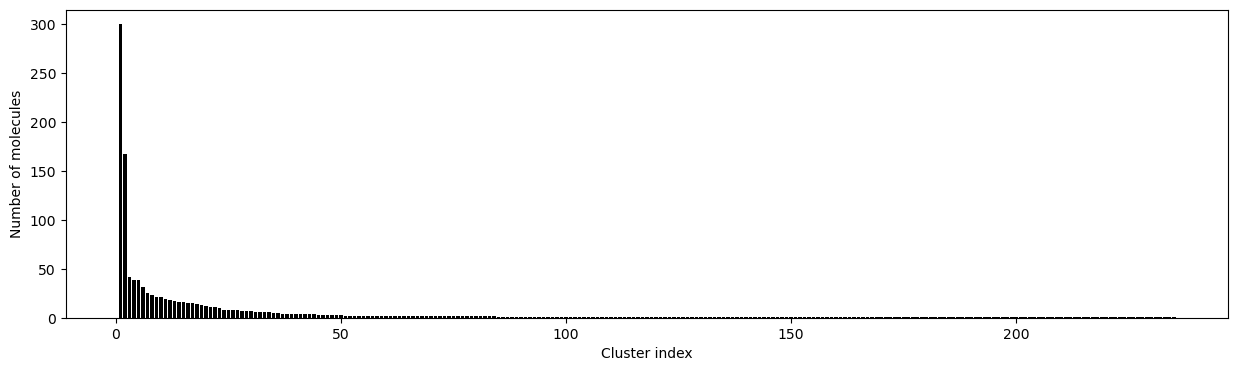

In [144]:
# Size of clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5, color='black')

plt.show()

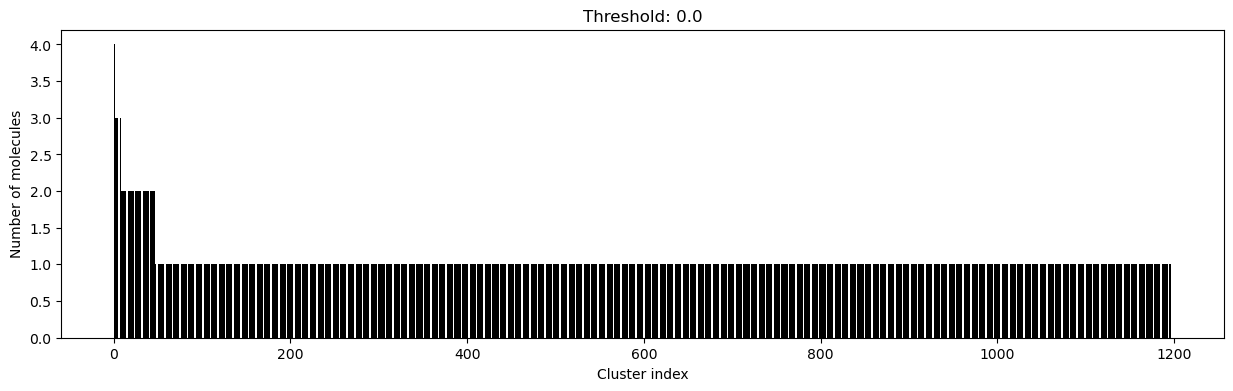

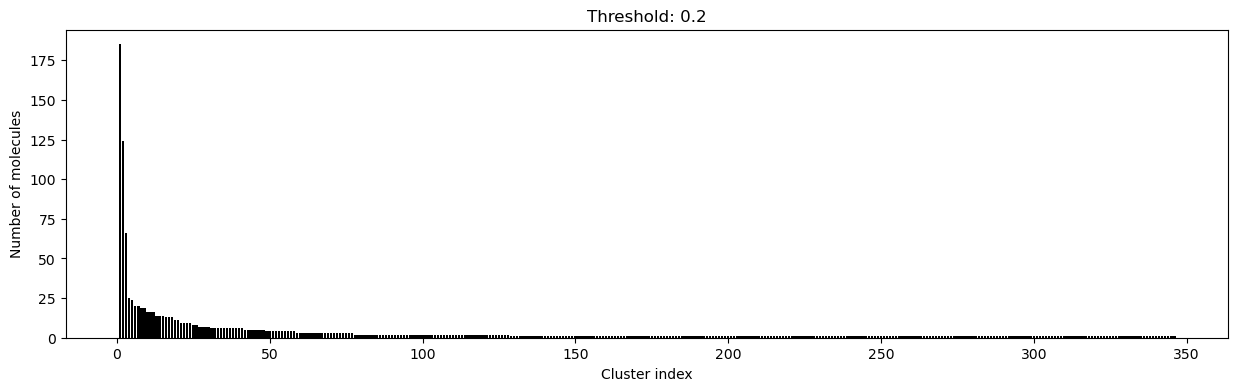

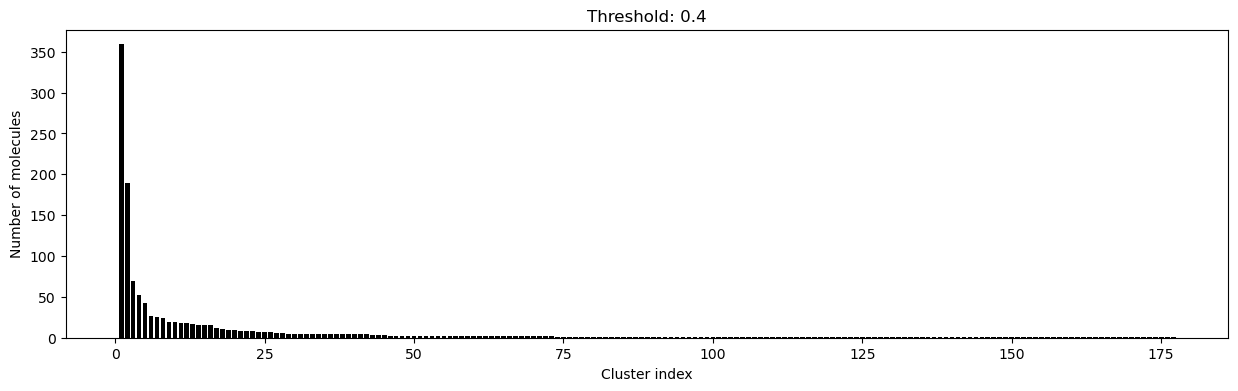

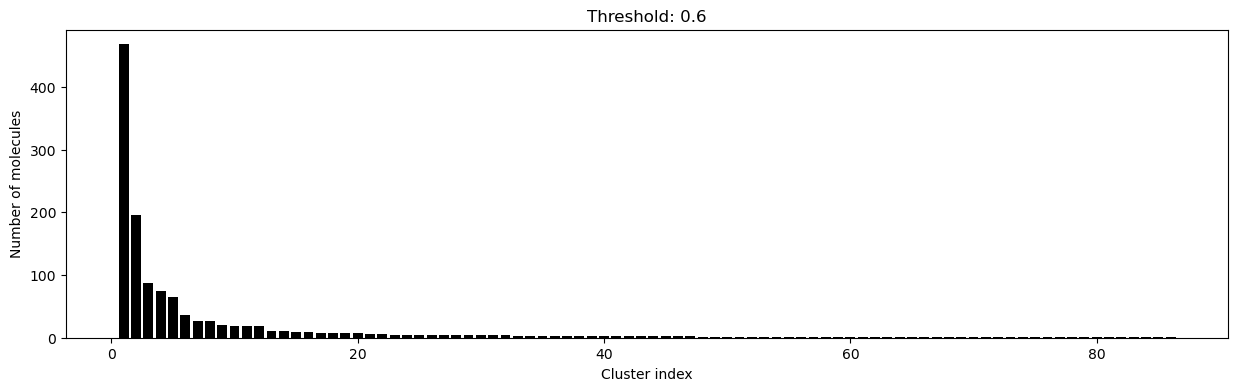

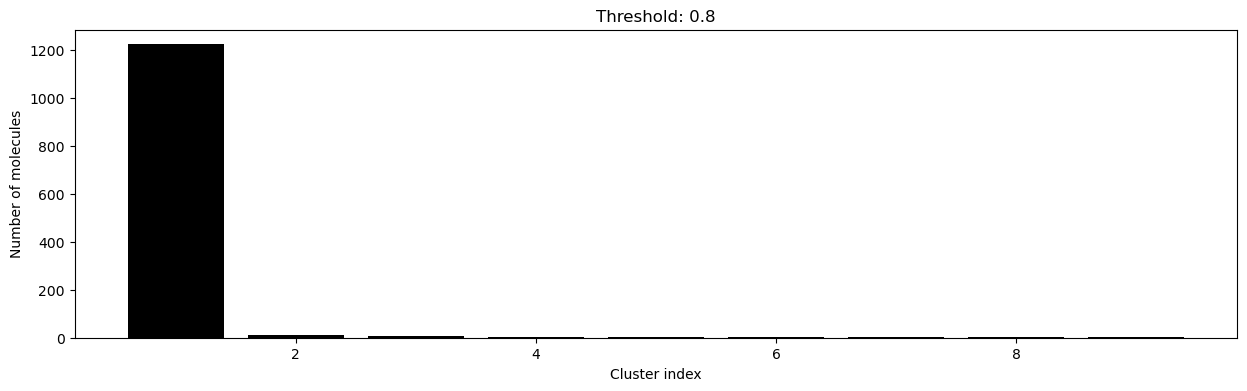

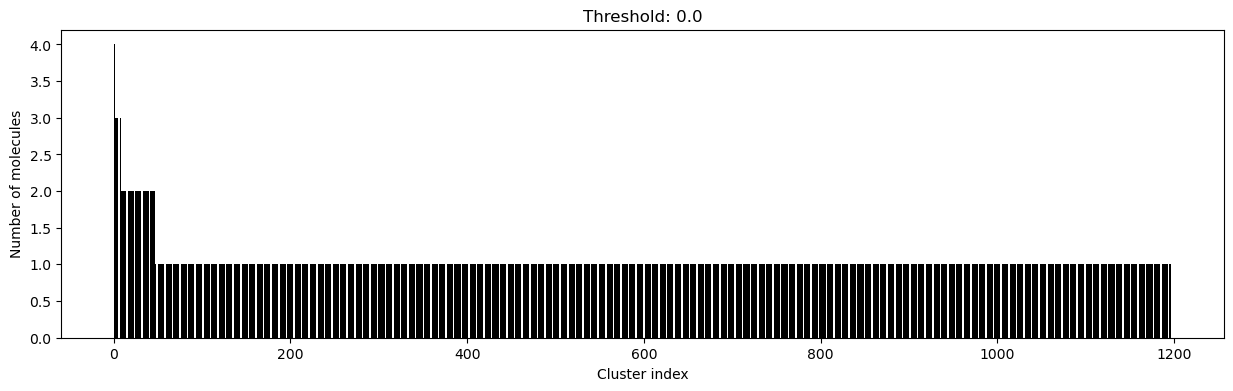

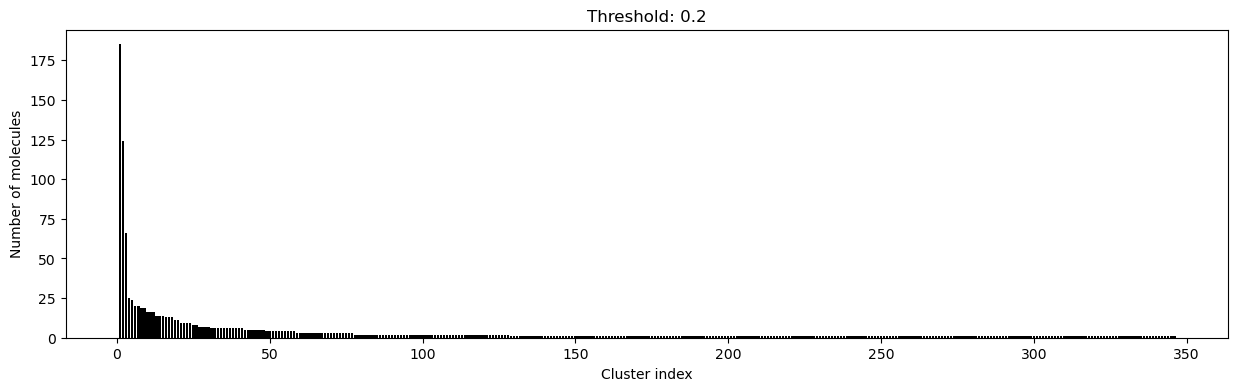

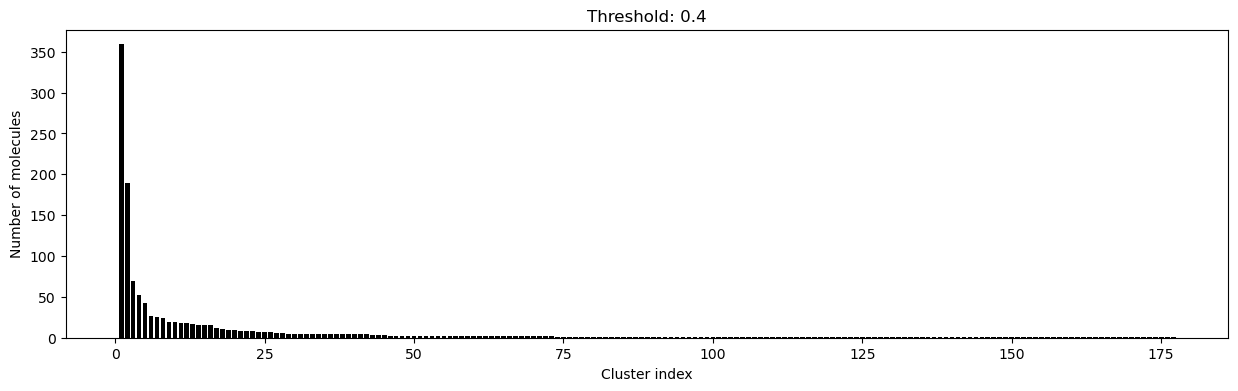

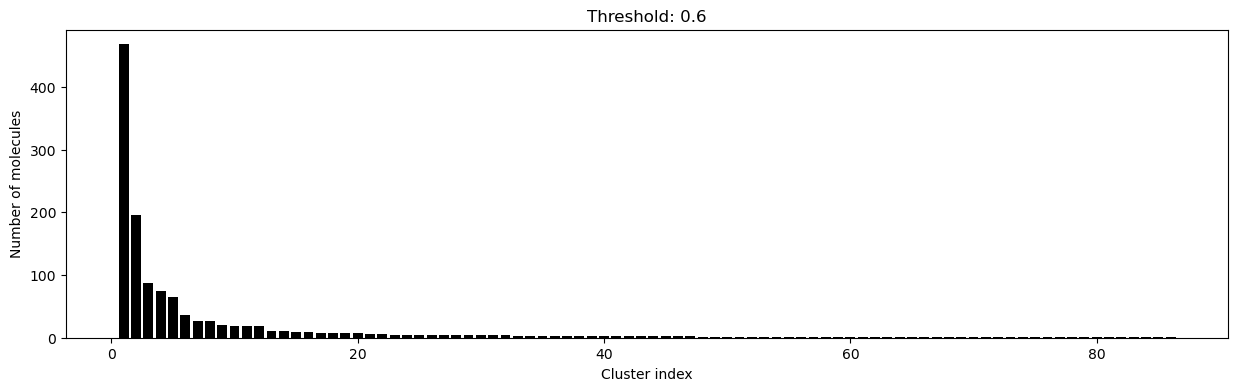

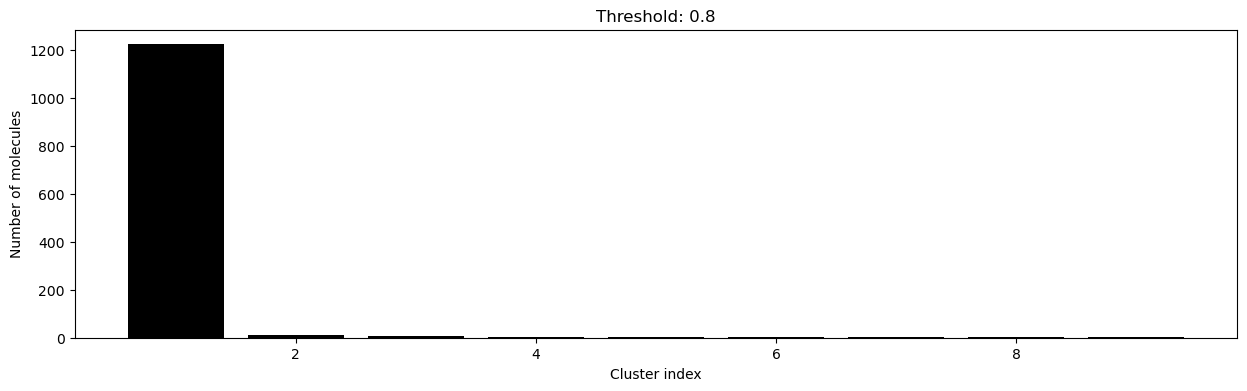

In [145]:
for cutoff in numpy.arange(0.0, 1.0, 0.2):
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5, color="black")
    display(fig)

As threshold increases(distance cutoff), we see that number of molecules in each cluster increase and the number of clusters decrease. The lower the value of the threshold, more lonely molecules will appear(singletons).

[As threshold decreases, number of clusters increase.]

Looking at the plots above, we decided to choose a distance threshold of 0.2. There are not many singletons and the cluster sizes don’t have an extreme but smooth distribution.



**After carefully reviewing the generated plots, distance threshold can be set for clustering at 0.2. This choice is motivated by several key observations. First, the analysis revealed that there are relatively few singleton clusters, indicating that the selected threshold effectively captures meaningful similarities between data points. Additionally, the distribution of cluster sizes exhibits a smooth pattern without extreme variations. This suggests that the chosen threshold strikes a balance, forming clusters that are both cohesive and reasonably sized.**

Hence_ cutoff = 0.4

Number of clusters: 177 from 1251 molecules at distance cut-off 0.40
Number of molecules in largest cluster: 359
Similarity between two random points in same cluster: 0.73
Similarity between two random points in different cluster: 0.23


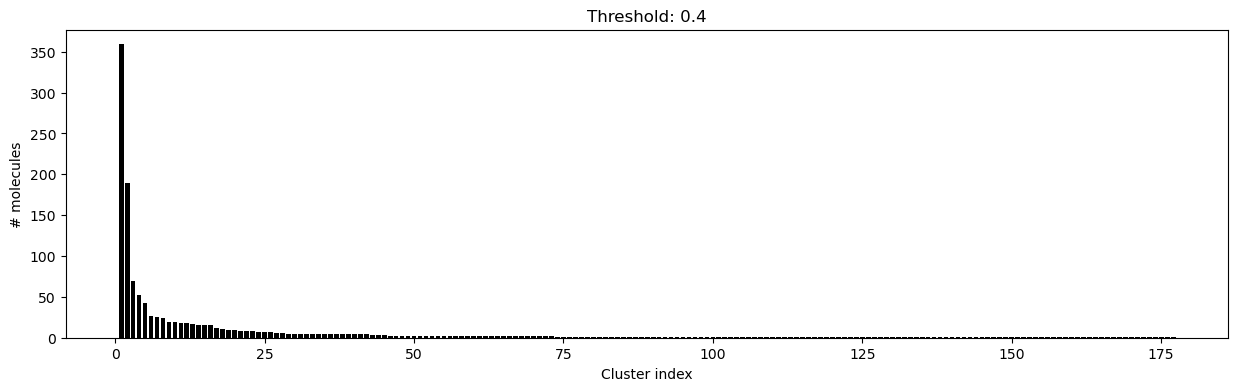

In [146]:
cutoff = 0.4
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], color="black")
ax.set_title(f"Threshold: {cutoff:3.1f}")

print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {cutoff:.2f}"
)
print("Number of molecules in largest cluster:", len(clusters[0]))
print(
    f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}"
)
print(
    f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}"
)

**VISUALISING THE CLUSTERS**

1. LARGEST CLUSTER

Ten molecules from largest cluster:


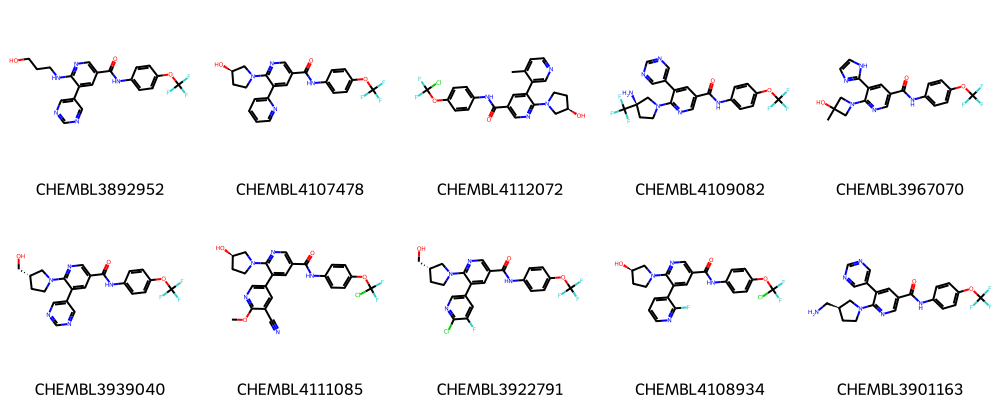

In [147]:
print("Ten molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[0][:10]],
    legends=[compounds[i][1] for i in clusters[0][:10]],
    molsPerRow=5,
)

In [148]:
# Assuming DATA is a directory path represented as a string
data_directory = "/Users/tejasigupta/Desktop/CADD_Testing"

# Convert the string to a Path object
data_path = Path(data_directory)

sdf_path = str(data_path / "molecule_set_largest_cluster.sdf")
sdf = Chem.SDWriter(sdf_path)

# The rest of your code remains unchanged
for index in clusters[0]:
    mol, label = compounds[index]
    mol.SetProp("_Name", label)
    sdf.write(mol)

sdf.close()


**Let us take a look at cluster centers of first 10 clusters**

Ten molecules from first 10 clusters:


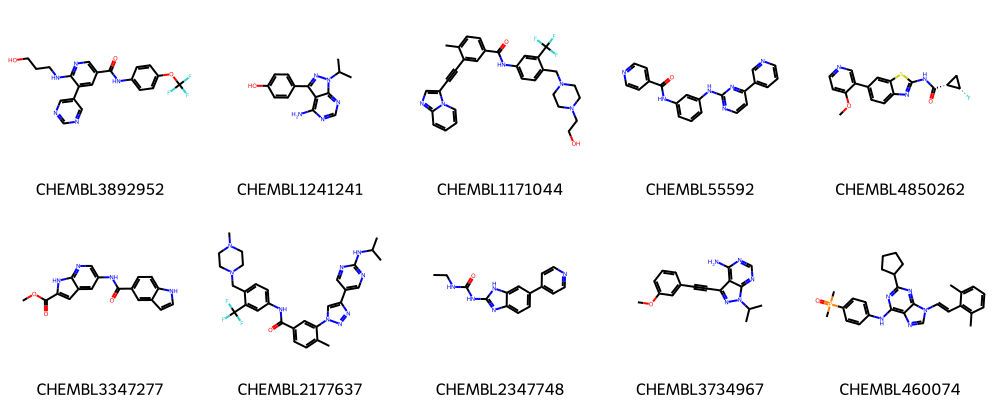

In [149]:
print("Ten molecules from first 10 clusters:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[clusters[i][0]][0] for i in range(10)],
    legends=[compounds[clusters[i][0]][1] for i in range(10)],
    molsPerRow=5,
)

In [150]:
# Generate image
img = Draw.MolsToGridImage(
    [compounds[clusters[i][0]][0] for i in range(0, 3)],
    legends=[f"Cluster {i}" for i in range(1, 4)],
    subImgSize=(200, 200),
    useSVG=True,
)

# Patch RAW svg data: convert non-transparent to transparent background and set font size
molsvg = img.data.replace("opacity:1.0", "opacity:0.0").replace("12px", "20px")

# Save altered SVG data to file
with open(data_path / "cluster_representatives.svg", "w") as f:
    f.write(molsvg)

**Intra-cluster Tanimoto similarities**

In [151]:
def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    # Calculate intra similarity per cluster
    for cluster in fps_clusters:
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

In [152]:
# Recompute fingerprints for 10 first clusters
mol_fps_per_cluster = []
for cluster in clusters[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster])

# Compute intra-cluster similarity
intra_similarity = intra_tanimoto(mol_fps_per_cluster)

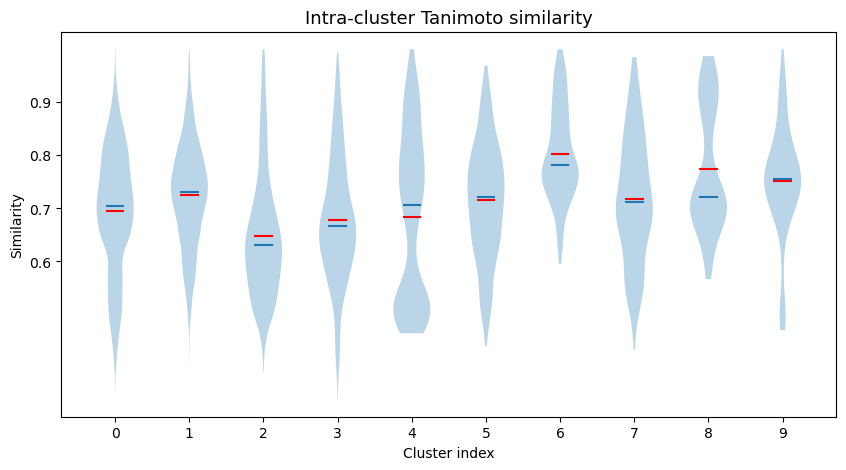

In [153]:
fig, ax = plt.subplots(figsize=(10, 5))
indices = list(range(10))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Similarity")
ax.set_xticks(indices)
ax.set_xticklabels(indices)
ax.set_yticks(numpy.arange(0.6, 1.0, 0.1))
ax.set_title("Intra-cluster Tanimoto similarity", fontsize=13)
r = ax.violinplot(intra_similarity, indices, showmeans=True, showmedians=True, showextrema=False)
r["cmeans"].set_color("red")
# mean=red, median=blue

**HOW TO PICK UP THE FINAL LIST OF COMPOUNDS**

We can do this by starting from the largest cluster

Pick the 10 molecules or 50% of the molecules if there are less than 10 molecules in the cluster. The molecules should be most similar to the centroid of the cluster.

The goal is to create a list of compounds

Max compound limit:1000

The selected compounds are expected to provide insights into the structure-activity relationships (SAR) because they are chosen based on their similarity to the cluster centroids.
SAR is crucial in drug discovery and other fields where the relationship between the chemical structure of a compound and its biological activity is studied.

1. Get cluster centres

In [154]:
# Get the cluster center of each cluster (first molecule in each cluster)
cluster_centers = [compounds[c[0]] for c in clusters]
# How many cluster centers/clusters do we have?
print("Number of cluster centers:", len(cluster_centers))

Number of cluster centers: 177


In [155]:
# Sort the molecules within a cluster based on their similarity to the centroid and sort the clusters based on their size
sorted_clusters = []
for cluster in clusters:
    if len(cluster) <= 1:
        continue  # Singletons
    # else:
    # Compute fingerprints for each cluster element
    sorted_fingerprints = [rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster]
    # Similarity of all cluster members to the cluster center
    similarities = DataStructs.BulkTanimotoSimilarity(
        sorted_fingerprints[0], sorted_fingerprints[1:]
    )
    # Add index of the molecule to its similarity (centroid excluded!)
    similarities = list(zip(similarities, cluster[1:]))
    # Sort in descending order by similarity
    similarities.sort(reverse=True)
    # Save cluster size and index of molecules in clusters_sort
    sorted_clusters.append((len(similarities), [i for _, i in similarities]))
    # Sort in descending order by cluster size
    sorted_clusters.sort(reverse=True)

In [156]:
# Count selected molecules, pick cluster centers first
selected_molecules = cluster_centers.copy()
# Take 10 molecules (or a maximum of 50%) of each cluster starting with the largest one
index = 0
pending = 1000 - len(selected_molecules)
while pending > 0 and index < len(sorted_clusters):
    # Take indices of sorted clusters
    tmp_cluster = sorted_clusters[index][1]
    # If the first cluster is > 10 big then take exactly 10 compounds
    if sorted_clusters[index][0] > 10:
        num_compounds = 10
    # If smaller, take half of the molecules
    else:
        num_compounds = int(0.5 * len(tmp_cluster)) + 1
    if num_compounds > pending:
        num_compounds = pending
    # Write picked molecules and their structures into list of lists called picked_fps
    selected_molecules += [compounds[i] for i in tmp_cluster[:num_compounds]]
    index += 1
    pending = 1000 - len(selected_molecules)
print("# Selected molecules:", len(selected_molecules))
# NBVAL_CHECK_OUTPUT

# Selected molecules: 459


In [157]:
sampled_mols = compounds.copy()

In [158]:
# Helper function for time computation
def measure_runtime(sampled_mols):
    start_time = time.time()
    sampled_fingerprints = [rdkit_gen.GetFingerprint(m) for m, idx in sampled_mols]
    # Run the clustering with the dataset
    sampled_clusters = cluster_fingerprints(sampled_fingerprints, cutoff=0.3)
    return time.time() - start_time

In [159]:
len(sampled_mols)


1251

In [160]:
sample_sizes = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
runtimes = []
# Take random samples with replacement
for size in sample_sizes:
    time_taken = measure_runtime(random.sample(sampled_mols, size))
    print(f"Dataset size {size}, time {time_taken:4.2f} seconds")
    runtimes.append(time_taken)

Dataset size 50, time 0.03 seconds
Dataset size 100, time 0.05 seconds
Dataset size 150, time 0.09 seconds
Dataset size 200, time 0.10 seconds
Dataset size 250, time 0.12 seconds
Dataset size 300, time 0.15 seconds
Dataset size 350, time 0.17 seconds
Dataset size 400, time 0.20 seconds
Dataset size 450, time 0.23 seconds
Dataset size 500, time 0.25 seconds


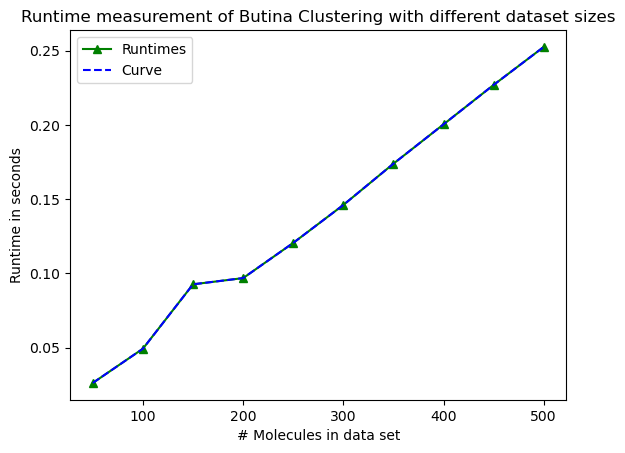

In [161]:
fig, ax = plt.subplots()
ax.set_title("Runtime measurement of Butina Clustering with different dataset sizes")
ax.set_xlabel("# Molecules in data set")
ax.set_ylabel("Runtime in seconds")

ax.plot(sample_sizes, runtimes, "g^-", label="Runtimes")

ax.plot(sample_sizes, runtimes, "b--", label="Curve")

ax.legend()

plt.show()


**WHY DID WE CLUSTER THE COMPOUNDS?**

Clustering is vital for drug discovery. Similar molecules often exhibit similar biological activities. By clustering molecules based on their structural or chemical features, researchers can focus their efforts on specific clusters, potentially speeding up the drug discovery process. It helps in identifying lead compounds and optimizing them for better efficacy and safety.

## **MAXIMUM COMMON SUBSTRUCTURES**


In [162]:
from collections import defaultdict
from copy import deepcopy
import random

from ipywidgets import interact, fixed, widgets
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools

In [163]:
# Import largest cluster sdf file made in clustering
sdf = str("molecule_set_largest_cluster.sdf")
supplier = Chem.ForwardSDMolSupplier(sdf)
mols = list(supplier)

print(f"Set with {len(mols)} molecules loaded.")

Set with 359 molecules loaded.


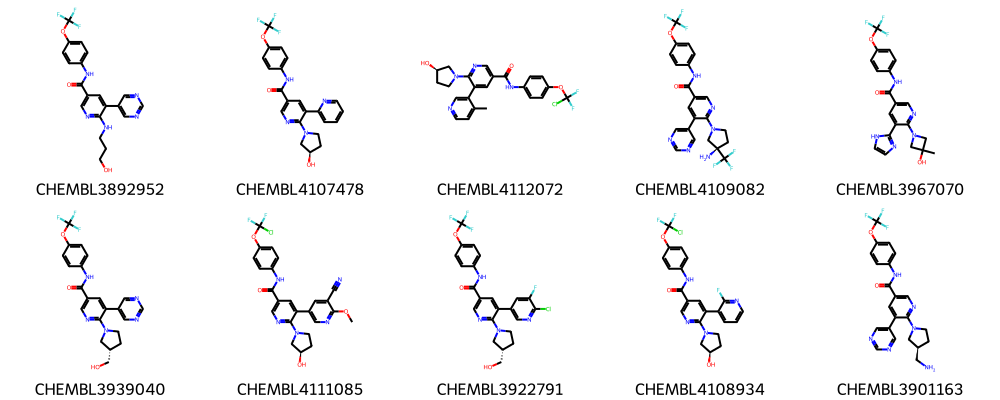

In [164]:
# Show first 10 molecules
n = 10
legends = [mol.GetProp("_Name") for mol in mols]
Draw.MolsToGridImage(mols[:n], legends=legends[:n], molsPerRow=5)



## 8. Maximum Common Substructure (MCS)

MCS analysis is performed on highly active compounds (pIC50 > 9.0).

ringMatchesRingOnly=True ensures chemically meaningful scaffold extraction.


**RUN FMCS ALGORITHM**

In [165]:
# Find the Maximum Common Substructure (MCS) in a set of molecules (mols)
mcs1 = rdFMCS.FindMCS(mols) 
print(f"MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.")
print("MCS SMARTS string:", mcs1.smartsString)

MCS1 contains 14 atoms and 13 bonds.
MCS SMARTS string: [#8]=[#6](-[#7]-[#6](:[#6]):[#6]:[#6]:[#6])-[#6](:[#6]):[#6]:[#6](:,-[#6])-,:[#6]


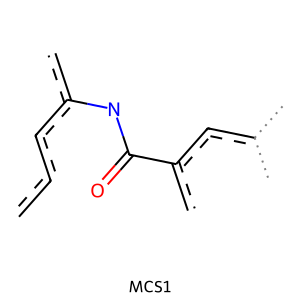

In [166]:
# Convert the SMARTS string of the Maximum Common Substructure (MCS1) to an RDKit molecule object
m1 = Chem.MolFromSmarts(mcs1.smartsString)
# Use RDKit's Draw.MolToImage to generate an image representation of the MCS1 molecule
Draw.MolToImage(m1, legend="MCS1")

In [167]:
''' 
The function creates a deep copy of the input list of molecules (mols) to avoid modifying the original objects. It then 
converts the SMARTS string representation of the Maximum Common Substructure (mcs1) to an RDKit molecule object using 
Chem.MolFromSmarts. It finds the matching atoms in each molecule for the given MCS using GetSubstructMatch. 
If the label parameter is set to True (which is the default), it generates legends for the molecules using the "_Name" 
property of each molecule. If the same_orientation parameter is set to True (which is the default), it aligns the molecules 
by the matched substructure. This ensures that the molecules are depicted in the same orientation for better visual comparison. 
Then, the function generates first 5 molecules with the highlighted MCS. 
'''


def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    # Create a deep copy of the input molecules to avoid modifying the original objects
    molecules = deepcopy(molecules)

    # Convert MCS to a molecule object using its SMARTS string representation
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    # If label is True, get molecule names for use in legends
    legends = None
    if label is True:
        legends = [x.GetProp("_Name") for x in molecules]

    # Align moleules by matched substructure so they are depicted in the same orientation
    # Adapted from: https://gist.github.com/greglandrum/82d9a86acb3b00d3bb1df502779a5810
    if same_orientation:
        # Compute 2D coordinates for the first molecule and its matched substructure
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        # Apply the computed 2D coordinates to the remaining molecules using a coordinate map
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)
    
    ''' 
    If same_orientation is set to True, this part aligns the molecules by the matched substructure. 
    It computes 2D coordinates for the atoms involved in the matching substructure of the first molecule and 
    then applies these coordinates to the other molecules. This ensures that molecules are depicted in a consistent 
    orientation, facilitating visual comparison.
    '''
    # Use RDKit's Draw.MolsToGridImage to generate an image of the molecules with highlighted MCS
    return Draw.MolsToGridImage(
        molecules[:number],
        legends=legends,
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )

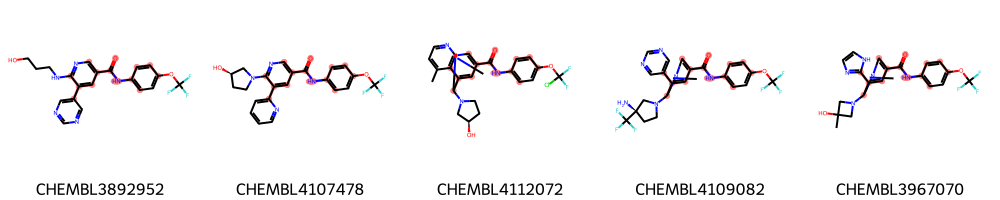

In [168]:
# Display first 5 molecules 
highlight_molecules(mols, mcs1, 5)

In [169]:
img = highlight_molecules(mols, mcs1, 3, useSVG=True)

# Get SVG data
molsvg = img.data

# Set background to transparent & Enlarge size of label
molsvg = molsvg.replace("opacity:1.0", "opacity:0.0").replace("12px", "20px")

# Save altered SVG data to file
with open("mcs_largest_cluster.svg", "w") as f:
    f.write(molsvg)

Threshold: 100%

It is possible to lower the threshold for the substructure, for example so that the MCS only has to occur in e.g. 80% of the input structures.

In [170]:
# Now, we set the threshold parameter is set to 1.0, indicating that the MCS must cover the entire set of molecules.
mcs2 = rdFMCS.FindMCS(mols, threshold=1.0) 
print(f"MCS2 contains {mcs2.numAtoms} atoms and {mcs2.numBonds} bonds.")
print("SMARTS string:", mcs2.smartsString)

MCS2 contains 14 atoms and 13 bonds.
SMARTS string: [#8]=[#6](-[#7]-[#6](:[#6]):[#6]:[#6]:[#6])-[#6](:[#6]):[#6]:[#6](:,-[#6])-,:[#6]


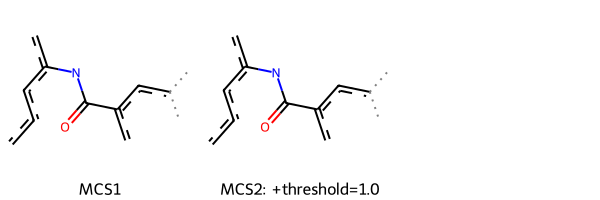

In [171]:
# Draw substructure
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolsToGridImage([m1, m2], legends=["MCS1", "MCS2: +threshold=1.0"])

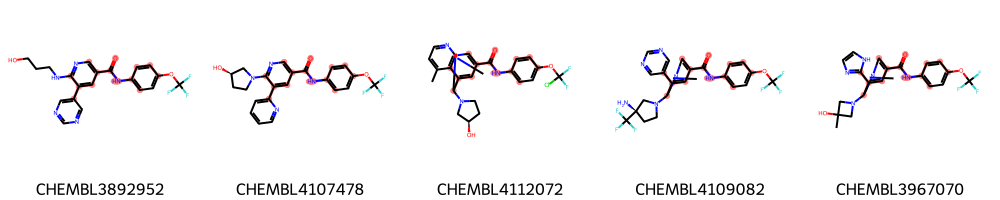

In [172]:
highlight_molecules(mols, mcs2, 5)

In [173]:
# Include ring matches
mcs3 = rdFMCS.FindMCS(mols, threshold=1.0, ringMatchesRingOnly=True)
print(f"MCS3 contains {mcs3.numAtoms} atoms and {mcs3.numBonds} bonds.")
print("SMARTS string:", mcs3.smartsString)

MCS3 contains 14 atoms and 13 bonds.
SMARTS string: [#8&!R]=&!@[#6&!R](-&!@[#7&!R]-&!@[#6&R](:&@[#6&R]):&@[#6&R]:&@[#6&R]:&@[#6&R])-&!@[#6&R](:&@[#6&R]):&@[#6&R]:&@[#6&R](:&@[#6&R])-&!@[#6&R]


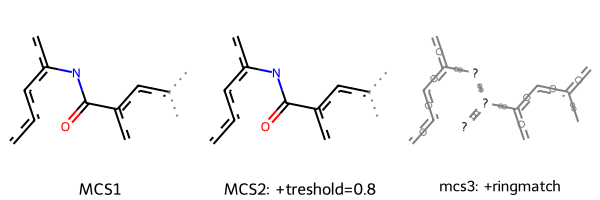

In [174]:
# Draw substructure
m3 = Chem.MolFromSmarts(mcs3.smartsString)
Draw.MolsToGridImage([m1, m2, m3], legends=["MCS1", "MCS2: +treshold=0.8", "mcs3: +ringmatch"])

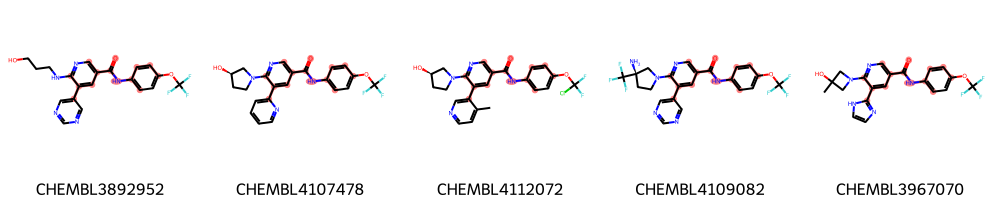

In [175]:
highlight_molecules(mols, mcs3, 5)

**Now, we can test on RET compounds using CSV file RET_compounds.csv**

In [176]:
# Read full ABL data
mol_df = pd.read_csv("RET_compounds.csv")
print("Total number of compounds:", mol_df.shape[0])

# Only keep molecules with pIC50 > 9 (IC50 > 1nM)
mol_df = mol_df[mol_df.pIC50 > 9]
print("Number of compounds with pIC50 > 9:", mol_df.shape[0])

Total number of compounds: 1474
Number of compounds with pIC50 > 9: 98


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL2347725,0.015,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909,
1,CHEMBL2347722,0.021,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781,
2,CHEMBL2347723,0.064,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820,

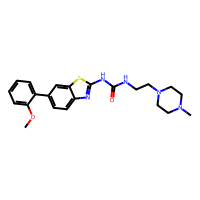
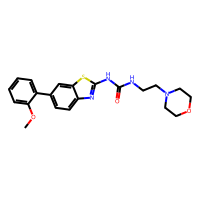
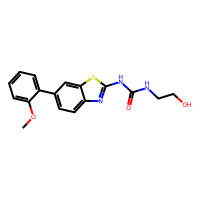

In [177]:
# Add molecule column to data frame
PandasTools.AddMoleculeColumnToFrame(mol_df, "smiles")
mol_df.head(3)

In [178]:
mols_diverse = []
# Note: discarded variables we do not care about are usually referred to with a single underscore
for _, row in mol_df.iterrows():
    m = Chem.MolFromSmiles(row.smiles)
    m.SetProp("_Name", row.molecule_chembl_id)
    mols_diverse.append(m)

In [179]:
# We have fixed the random seed above (imports) for deterministic results
mols_diverse_sample = random.sample(mols_diverse, 29)


In [180]:
threshold_diverse = 0.2
mcs1 = rdFMCS.FindMCS(mols_diverse_sample)
print("SMARTS string1:", mcs1.smartsString)
mcs2 = rdFMCS.FindMCS(mols_diverse_sample, threshold=threshold_diverse)
print("SMARTS string2:", mcs2.smartsString)
mcs3 = rdFMCS.FindMCS(mols_diverse_sample, ringMatchesRingOnly=True, threshold=threshold_diverse)
print("SMARTS string3:", mcs3.smartsString)

SMARTS string1: [#6]:,-[#7]:,-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1
SMARTS string2: [#8]=[#6](-[#7]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#8]-[#6](-[#9])(-[#9])-[#9])-[#6]1:[#6]:[#7]:[#6](:[#6](:[#6]:1)-[#6]1:[#6]:[#6]:[#6]:[#7]:[#6]:1)-[#7](-[#6]-[#6]-[#6]-[#8])-[#6]
SMARTS string3: [#8&!R]=&!@[#6&!R](-&!@[#7&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#6&R]:&@[#6&R]:&@1)-&!@[#8&!R]-&!@[#6&!R](-&!@[#9&!R])(-&!@[#9&!R])-&!@[#9&!R])-&!@[#6&R]1:&@[#6&R]:&@[#7&R]:&@[#6&R](:&@[#6&R](:&@[#6&R]:&@1)-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#7&R]:&@[#6&R]:&@1)-&!@[#7&R]1-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@1


Setting ringMatchesRingOnly=True provides a more intuitive representation of the scaffold they share.

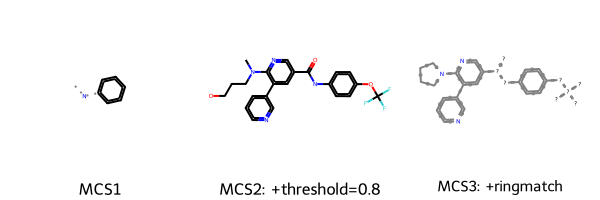

In [181]:
# Draw substructures
m1 = Chem.MolFromSmarts(mcs1.smartsString)
m2 = Chem.MolFromSmarts(mcs2.smartsString)
m3 = Chem.MolFromSmarts(mcs3.smartsString)

Draw.MolsToGridImage(
    [m1, m2, m3],
    legends=[
        "MCS1",
        f"MCS2: +threshold=0.8",
        "MCS3: +ringmatch",
    ],
)

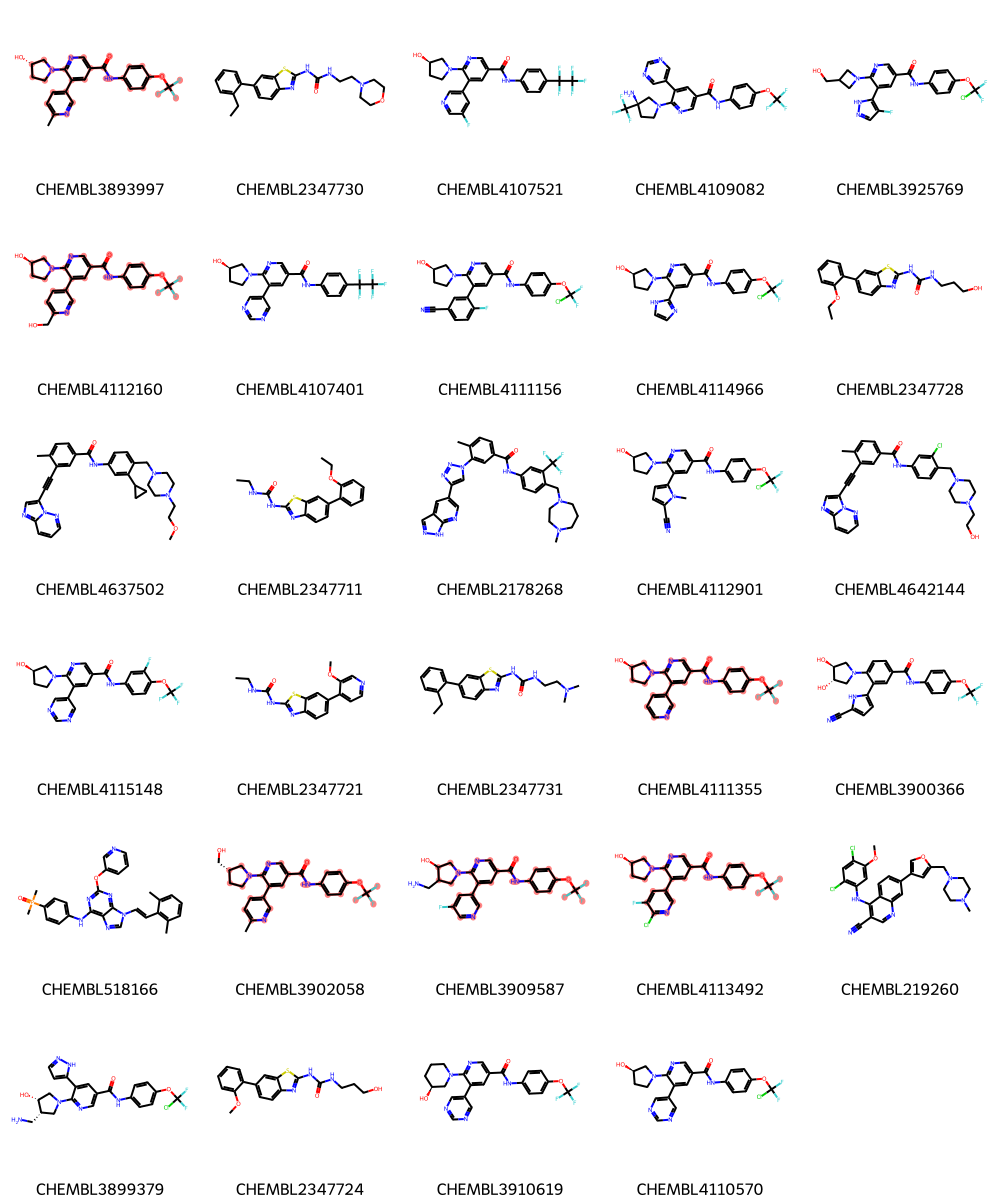

In [182]:
highlight_molecules(mols_diverse_sample, mcs3, 100)

**Structure-Activity Relationship (SAR) Analysis: Analyzing common substructures across a set of compounds allows us to establish structure-activity relationships. By correlating variations in chemical structure with changes in biological activity, researchers can gain insights into the molecular basis of drug-receptor interactions.**

# Machine Learning

In [183]:
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator

'''
# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22
seed_everything(SEED)
'''

'\n# Silence some expected warnings\nfilterwarnings("ignore")\n# Fix seed for reproducible results\nSEED = 22\nseed_everything(SEED)\n'

In [184]:
# Read data from previous talktorials
chembl_df = pd.read_csv("RET_compounds_lipinski.csv")

# Look at head
print("Shape of dataframe : ", chembl_df.shape)
chembl_df.head()
# NBVAL_CHECK_OUTPUT

Shape of dataframe :  (1251, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL2347725,0.015,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909,425.188546,6,2,3.3408,True
1,CHEMBL2347722,0.021,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781,412.156912,6,2,3.4256,True
2,CHEMBL2347723,0.064,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820,343.099062,5,3,3.0857,True
3,CHEMBL2347711,0.064,nM,CCNC(=O)Nc1nc2ccc(-c3ccccc3OCC)cc2s1,10.193820,341.119798,4,2,4.5034,True
4,CHEMBL2347719,0.110,nM,CCNC(=O)Nc1nc2ccc(-c3ccc(N)cc3OC)cc2s1,9.958607,342.115047,5,3,3.6955,True


In [185]:
# Keep only the columns we want
chembl_df = chembl_df[["molecule_chembl_id", "smiles", "pIC50"]]
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50
0,CHEMBL2347725,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909
1,CHEMBL2347722,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781
2,CHEMBL2347723,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820
3,CHEMBL2347711,CCNC(=O)Nc1nc2ccc(-c3ccccc3OCC)cc2s1,10.193820
4,CHEMBL2347719,CCNC(=O)Nc1nc2ccc(-c3ccc(N)cc3OC)cc2s1,9.958607


**DATA PREPARATION**

A common cut-off value to discretize pIC50 data is 6.3, which we will use for our experiment (refer to J. Med. Chem. (2017), 60, 474-485)

In [186]:
# Add column for activity
chembl_df["active"] = np.zeros(len(chembl_df))

# Mark every molecule as active with an pIC50 of >= 6.3, 0 otherwise
chembl_df.loc[chembl_df[chembl_df.pIC50 >= 6.3].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(chembl_df.active.sum()))
print("Number of inactive compounds:", len(chembl_df) - int(chembl_df.active.sum()))

Number of active compounds: 877
Number of inactive compounds: 374


In [187]:
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,active
0,CHEMBL2347725,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909,1.0
1,CHEMBL2347722,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781,1.0
2,CHEMBL2347723,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820,1.0
3,CHEMBL2347711,CCNC(=O)Nc1nc2ccc(-c3ccccc3OCC)cc2s1,10.193820,1.0
4,CHEMBL2347719,CCNC(=O)Nc1nc2ccc(-c3ccc(N)cc3OC)cc2s1,9.958607,1.0


In [188]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [189]:
compound_df = chembl_df.copy()

In [190]:
# Add column for fingerprint
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,active,fp
0,CHEMBL2347725,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL2347722,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL2347723,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Function to plot ROC curve**

In [193]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"{DATA}/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

## 9. Supervised Learning Model

An MLP classifier is trained to distinguish active vs inactive compounds using fingerprint features.

Performance metric: ROC–AUC


**Function to calculate model performance**

In [194]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

**Helper function to fit a machine learning model on a random train-test split of the data and return the performance measures.**

In [195]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

In [196]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 1000
Test data size: 251


**Neural Network Classifier**

In [236]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5,3))

# Fit model on single split``
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.86
Specificity: 0.78
AUC: 0.91


/Users/tejasigupta/opt/miniconda3/envs/pythonenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


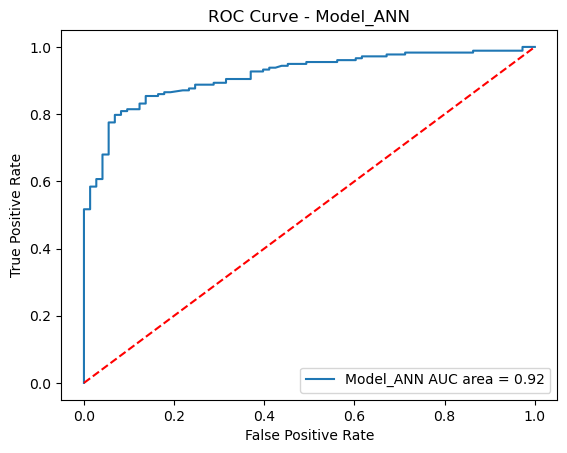

In [233]:
# Create a list to hold the ANN model
models = [{"label": "Model_ANN", "model": model_ANN}]

# Plot ROC curve for ANN model
plot_roc_curves_for_models(models, static_test_x, static_test_y)
plt.title('ROC Curve - Model_ANN')
plt.show()

## Conclusion

From an initial dataset of 2307 compounds, 29 candidate molecules were identified through sequential filtering, similarity screening, clustering, and scaffold analysis.

The trained neural network achieved ROC–AUC = 0.92, indicating that fingerprint-based features capture relevant activity patterns for ABL1 inhibition.

This framework can be extended to large-scale database screening.


## References:

• Abel, A., Malave-Ramos, D. R., Soni, B., Thai, C., Wu-Wu, A., Goodsell, D. S., & Burley, S. K. (July 2023). Molecule of
the Month: c-Abl Protein Kinase and Imatinib

• Motaln H, Rogelj B. The Role of c-Abl Tyrosine Kinase in Brain and Its Pathologies. Cells. 2023; 12(16):2041.
https://doi.org/10.3390/cells12162041

• Zhou, Z. H., Wu, Y. F., Wang, X. M., & Han, Y. Z. (2017). The c-Abl inhibitor in Parkinson disease. Neurological sciences :
official journal of the Italian Neurological Society and of the Italian Society of Clinical Neurophysiology, 38(4), 547–
552. https://doi.org/10.1007/s10072-016-2808-2

• Lipinski, Christopher & Lombardo, Franco & Dominy, B.W. & Feeney, P.J.. (1997). Experimental and omputational
approaches to estimate solubility and permeability in drug discovery and development settings. Adv. Drug Delivery
Rev.. 3. 23-25.

• Ritchie, T. J., Ertl, P., & Lewis, R. (2011). The graphical representation of ADME-related molecule properties for
medicinal chemists. Drug discovery today, 16(1-2), 65–72. https://doi.org/10.1016/j.drudis.2010.11.002

• Brenk, Ruth & Schipani, Alessandro & James, Daniel & Krasowski, Agata & Gilbert, Ian & Frearson, Julie & Wyatt, Paul.
(2008). Lessons Learnt from Assembling Screening Libraries for Drug Discovery for Neglected Diseases.
ChemMedChem. 3. 435-44. 10.1002/cmdc.200700139.

• Baell, Jonathan & Holloway, Georgina. (2010). New Substructure Filters for Removal of Pan Assay Interference
Compounds (PAINS) from Screening Libraries and for Their Exclusion in Bioassays. Journal of medicinal chemistry.
53. 2719-40. 10.1021/jm901137j.

• J. Chem. Inf. Comput. Sci. 1999, 39, 4, 747–750

• John W. Raymond and Peter Willett. Maximum common subgraph isomorphism algorithms for the matching of
chemical structures . Journal of Computer-Aided Molecular Design, 2002, 16:521-533.

• Chemaxon. Maximum Common Substructure (MCS) search

• Lee J. Lancashire, Christophe Lemetre, Graham R. Ball, An introduction to artificial neural networks in
bioinformatics—application to complex microarray and mass spectrometry datasets in cancer studies, Briefings in
Bioinformatics, Volume 10, Issue 3, May 2009, Pages 315–329, https://doi.org/10.1093/bib/bbp012

• Hoo ZH, Candlish J, Teare D What is an ROC curve? Emergency Medicine Journal 2017;34:357-359.